## Description

This implements a version of OmniFold that simplifies step2 by always starting from weight=1 and training to distinguish raw gen MC with the current pull weights from step1.  That way, the final step2 NN is a single function that gives the final gen MC event weights.

In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from time import gmtime, strftime
import time
from stopwatch import Stopwatch, profile

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"]=False 

In [2]:
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>")

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2023-01-26 18:28:08.003577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 18:28:08.003802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 18:28:08.020508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 18:28:08.020747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 18:28:08.020919: I tensorflow/compiler/xla/stream_executo

In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.11.0


# OmniFold Gaussian Toy Example

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true


##-- original value
#back = 0.1 #fraction of a background process that we would like to subtract



## Owen: learning hyperparameters

In [7]:



##-- originals

#max_epochs = 200
#batch_size_setval = 10000
#learning_rate_setval = 1e-3
#patience_setval = 10

#back = 0.1 #fraction of a background process that we would like to subtract
#background_param = (0, 1.2)  # background
#N = 10**5






##-- alt1
##-- more thorough set with more events, higher background, wider background width 
##  3 min + 50 min

#max_epochs = 200
#batch_size_setval = 1000
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 3*10**5






##-- alt2
##-- more thorough set with a lot more events, higher background, wider background width 
##   About 3 hours.

#max_epochs = 200
#batch_size_setval = 1000
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 10**6



##-- alt4
##   similar to alt1 but with a much larger batch size.
##-- more thorough set with more events, higher background, wider background width 
##  about 30 min

#max_epochs = 200
#batch_size_setval = 16384
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 3*10**5



##-- alt5
##   similar to alt4 but with sample size of 1M.
##-- more thorough set with more events, higher background, wider background width 
##  about 30 min

max_epochs = 200
batch_size_setval = 16384
learning_rate_setval = 1e-4
patience_setval = 40

back = 0.2 #fraction of a background process that we would like to subtract
background_param = (0, 3)  # background
N = 10**6




stopwatch = Stopwatch()


In [8]:
%%time

#N = 10**5


# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (0.2, 0.8)  # this is the data (the target)
#background_param = (0, 1.2)  # background
#background_param = (0, 3)  # background
epsilon = sigma0 / 2.  # Smearing width

dummyval = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
theta0_G = np.random.normal(theta0_param[0], theta0_param[1],N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G])  # Detector smearing for synthetic sample
pass_reco = np.random.binomial(1,1.-eff,len(theta0_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta0_G)) # what a concise Toy MC with cuts!
theta0_S[pass_reco==0] = dummyval
theta0_G[pass_truth==0] = dummyval

theta0_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta0_S_withback = np.concatenate([theta0_S,theta0_background]) #smeared synthetic (mc_reco)+background
theta0_G_withback = np.concatenate([theta0_G,-np.ones(int(N*back))*dummyval]) #gen synthetic (mc_truth)+background

theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

#Natural
theta_unknown_G = np.random.normal(theta_unknown_param[0],theta_unknown_param[1], N) # Nature, particle-level analog
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta_unknown_G]) # Measured Data analog
pass_reco = np.random.binomial(1,1.-eff,len(theta_unknown_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta_unknown_G))
theta_unknown_S[pass_reco==0] = dummyval
theta_unknown_G[pass_truth==0] = dummyval #emulates cuts done in an analysis

theta_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta_unknown_S_withback = np.concatenate([theta_unknown_S,theta_background]) #Nature+background
theta_unknown_G_withback = np.concatenate([theta_unknown_G,-np.ones(int(N*back))*dummyval]) #Data+Background

theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

CPU times: user 5.29 s, sys: 7 ms, total: 5.3 s
Wall time: 5.3 s


In [9]:
theta0_G

array([  0.37523443, -10.        , -10.        , ...,   1.44792551,
        -1.08644681,   0.64920735])

In [10]:
theta0_S

array([-0.02867966, -0.20419971, -1.58445428, ...,  1.32531836,
       -1.41456049,  1.19944769])

In [11]:
theta0

array([[  0.37523443,  -0.02867966],
       [-10.        ,  -0.20419971],
       [-10.        ,  -1.58445428],
       ...,
       [  1.44792551,   1.32531836],
       [ -1.08644681,  -1.41456049],
       [  0.64920735,   1.19944769]])

In [12]:
labels0

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
labels0.shape

(1000000,)

In [14]:
theta0.shape

(1000000, 2)

In [15]:
labels_unknown

array([1., 1., 1., ..., 1., 1., 1.])

In [16]:
labels_unknown.shape

(1000000,)

/tmp/ipykernel_3062578/177983796.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


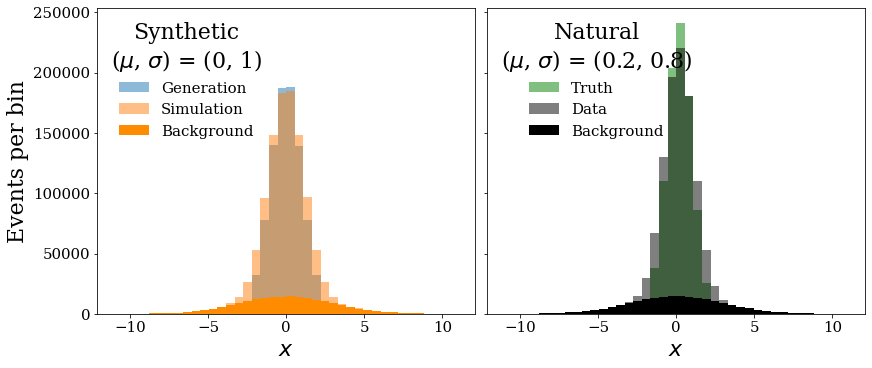

In [17]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S_withback[theta0_S_withback!=dummyval], bins=bins, **plot_style_2, label='Simulation')
ax[0].hist(theta0_S_withback[theta0_G_withback==-dummyval], bins=bins, color="darkorange", label='Background')
legend = ax[0].legend(
    title=r'Synthetic''\n''($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel(r'$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, **plot_style_2, label='Data',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_G_withback==-dummyval], bins=bins, label='Background',color="black")
legend = ax[1].legend(
    title=r'Natural''\n''($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [18]:
iterations = 4

In [19]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S)) #synthetic, measured.
yvals_1 = np.concatenate((labels0, labels_unknown)) 
#QUESTION: At what point are theses mixed? Avoid [0,0,0...0,1,1...1,1,1]
#I think at test_train_split function

xvals_2 = np.concatenate((theta0_G, theta0_G)) 
#QUESTION whay 0_G twice? Because theta_unknown_G is ultimate target (particle level – nature), 
#and can't be used as an input to the training.
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)


nn_output = np.zeros( shape=(iterations, 2, len(theta0)))

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

#earlystopping = EarlyStopping(patience=10,
#                              verbose=1,
#                              restore_best_weights=True)

earlystopping = EarlyStopping(patience=patience_setval,
                              verbose=1,
                              restore_best_weights=True)

2023-01-26 18:28:14.329143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 18:28:14.329353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 18:28:14.329527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 18:28:14.329689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 18:28:14.329851: I tensorflow/compiler/xla/stream_executo

In [20]:
xvals_1

array([ -0.02867966,  -0.20419971,  -1.58445428, ...,   1.32851636,
       -10.        , -10.        ])

In [21]:
xvals_1.shape

(2000000,)

In [22]:
yvals_1

array([0., 0., 0., ..., 1., 1., 1.])

In [23]:
yvals_1.shape

(2000000,)

In [24]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights)) 
#Question: how is the model passed? Stored in memory before function is called?
#QUESTION: is this p(w,X)/p(w',X'), where p is PDF of (x)?
#reweights sim to data, then 

In [25]:
%%time

#We can do the background subtraction as part of the iterative unfolding, but it is easier to do it first.


    
x_data_and_MCback = np.concatenate([theta0_S_withback[theta0_G_withback==-dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]])
    
y_data_and_MCback = np.concatenate([np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.zeros(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])
    
W_data_and_MCback = np.concatenate([-1.*np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)

    


CPU times: user 121 ms, sys: 12 ms, total: 133 ms
Wall time: 132 ms


## Owen's notes

See my more detailed notes in this file on my laptop: /Users/owen/work/eic/omnifold/2023-01-23-notes.docx

Here's a summary of how the BG subtraction works.  

- The NN is given a binary classification task where the two categories are signal-only (y=1, call this a) and signal plus background (y=0, call this b).

- The signal-only sample is constructed by combining the "data" (theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]) with a BG sample (theta0_S_withback[theta0_G_withback==-dummyval]), where the data weight is +1 and the BG weight is -1.  This does the BG subtraction in the loss function because the sum of the BG sample, with weight -1, will cancel the sum of the BG component of the data.

- The NN output f is an estimation of the probability that an event is in the class a and this is approximately a/(a+b).

- The signal fraction is given by a/b.  To get this from f, it's Fr(sig) = f/(1-f) = a/b, which is also the likelihood ratio or the ratio of the probabilities of the two classes.

This BG subtraction trick is to cancel it in the loss function by adding it to the signal+bg sample with a negative weight.


In [26]:
%%time

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'])

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'],
#              weighted_metrics=[])


#training_hist = model.fit(X_train_1,
#          Y_train_1,
#          sample_weight=w_train_1,
#          epochs=200,
#          batch_size=10000,
#          validation_data=(X_test_1, Y_test_1, w_test_1),
#          callbacks=[earlystopping],
#          verbose=1)


print("\n\n\n")
print (strftime("Current time:  %Y-%m-%d %H:%M:%S", gmtime()))
print("\n\n\n")

the_optimizer = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )

stopwatch.reset()
stopwatch.start()

model.compile(loss='binary_crossentropy',
              optimizer=the_optimizer,
              metrics=['accuracy'],
              weighted_metrics=[])

stopwatch.stop()
print("\n\n model.compile took this long:  %.2f" % stopwatch.elapsed )

stopwatch.reset()
stopwatch.start()

training_hist = model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=100,
          batch_size=batch_size_setval,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)

stopwatch.stop()
print("\n\n model.fit took this long:  %.2f" % stopwatch.elapsed )

print("\n\n\n")
print (strftime("Current time:  %Y-%m-%d %H:%M:%S", gmtime()))
print("\n\n\n")





Current time:  2023-01-27 02:28:15






 model.compile took this long:  0.00
Epoch 1/100


2023-01-26 18:33:08.870623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-26 18:33:08.872946: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f5d9431ff00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-26 18:33:08.872958: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-26 18:33:08.872961: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-26 18:33:08.876118: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-26 18:33:08.961090: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is log

110/110 [==============================] - 99s 898ms/step - loss: 0.5668 - accuracy: 0.4599 - val_loss: 0.5626 - val_accuracy: 0.4583
Epoch 2/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5628 - accuracy: 0.4584 - val_loss: 0.5611 - val_accuracy: 0.4591
Epoch 3/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5616 - accuracy: 0.4585 - val_loss: 0.5600 - val_accuracy: 0.4583
Epoch 4/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5606 - accuracy: 0.4583 - val_loss: 0.5589 - val_accuracy: 0.4583
Epoch 5/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5597 - accuracy: 0.4583 - val_loss: 0.5580 - val_accuracy: 0.4583
Epoch 6/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5590 - accuracy: 0.4583 - val_loss: 0.5574 - val_accuracy: 0.4583
Epoch 7/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5585 - accuracy: 0.4583 - val_loss: 0.5568 - val_accuracy: 0.4583
Epoch 8/

110/110 [==============================] - 0s 3ms/step - loss: 0.5558 - accuracy: 0.4583 - val_loss: 0.5537 - val_accuracy: 0.4583
Epoch 59/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5558 - accuracy: 0.4583 - val_loss: 0.5537 - val_accuracy: 0.4583
Epoch 60/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5558 - accuracy: 0.4583 - val_loss: 0.5537 - val_accuracy: 0.4583
Epoch 61/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5558 - accuracy: 0.4583 - val_loss: 0.5537 - val_accuracy: 0.4583
Epoch 62/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5558 - accuracy: 0.4583 - val_loss: 0.5537 - val_accuracy: 0.4583
Epoch 63/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5558 - accuracy: 0.4583 - val_loss: 0.5537 - val_accuracy: 0.4583
Epoch 64/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5558 - accuracy: 0.4583 - val_loss: 0.5537 - val_accuracy: 0.4583
Epoch

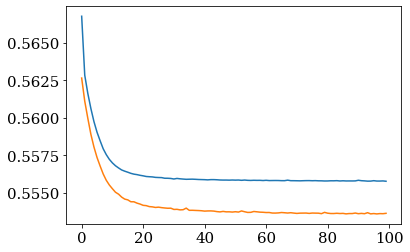

In [27]:
plt.plot( training_hist.history['loss'])
plt.plot( training_hist.history['val_loss'])

In [28]:
w_data = reweight(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])

110/110 [==============================] - 0s 580us/step


In [29]:
w_data_bgsub_only = w_data

/tmp/ipykernel_3062578/236819712.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


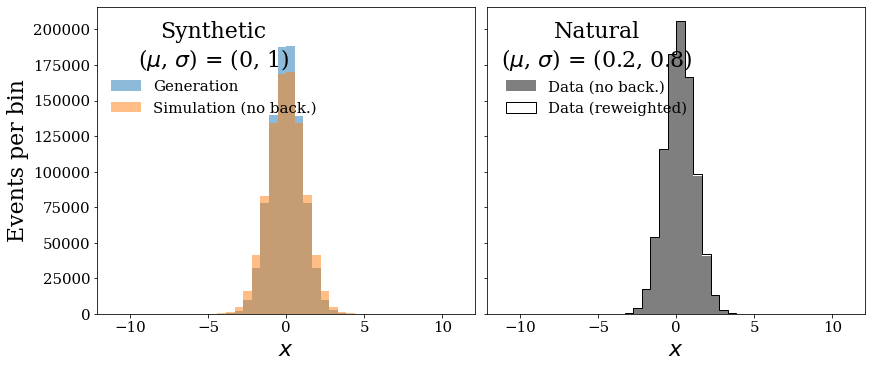

In [30]:
i=0
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S!=dummyval], bins=bins, **plot_style_2, label='Simulation (no back.)')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
#ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S[theta_unknown_S!=dummyval], bins=bins, **plot_style_2, label='Data (no back.)',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, histtype="step", label='Data (reweighted)',color="black",weights=w_data)
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()
plt.savefig("plot_"+str(i)+"_datareweight.pdf")

In [31]:
model_output_bgsub = model.predict(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], batch_size=10000)

110/110 [==============================] - 0s 607us/step


In [32]:
model_output_bgsub

array([[0.45264393],
       [0.4813909 ],
       [0.4815198 ],
       ...,
       [0.05133212],
       [0.4764351 ],
       [0.45331067]], dtype=float32)

In [33]:
model_output_bgsub.shape

(1099334, 1)

In [34]:
squeezed_model_output = np.squeeze(model_output_bgsub)

In [35]:
squeezed_model_output

array([0.45264393, 0.4813909 , 0.4815198 , ..., 0.05133212, 0.4764351 ,
       0.45331067], dtype=float32)

In [36]:
squeezed_model_output.shape

(1099334,)

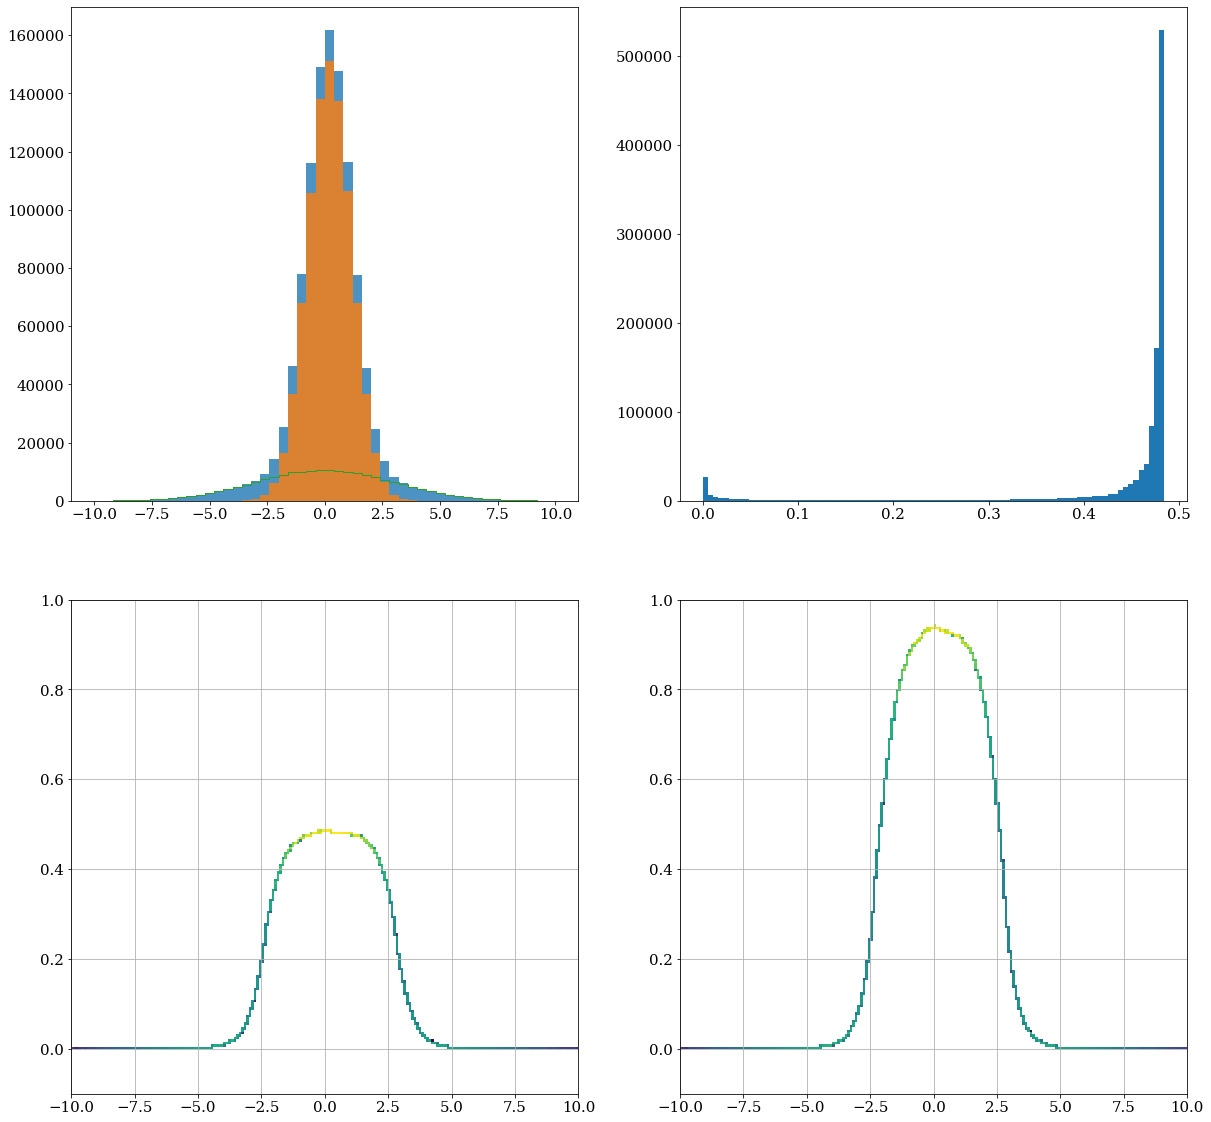

In [37]:
fig,ax = plt.subplots(2,2,figsize=(20,20))



ax[0][0].hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_background, range=[-10,10], bins=50, histtype="step")

ax[0][1].hist( squeezed_model_output, bins=90 )


ax[1][0].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         squeezed_model_output,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][0].grid()

ax[1][1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][1].grid()

plt.show()

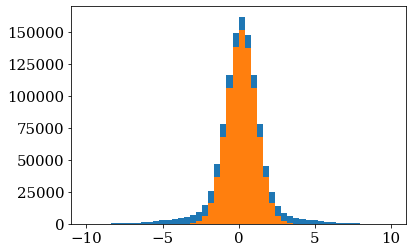

In [38]:
hist_data_all = plt.hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50 )
hist_data_signal = plt.hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50)

In [39]:
hist_data_all

(array([4.80000e+01, 8.30000e+01, 1.12000e+02, 1.86000e+02, 2.68000e+02,
        3.45000e+02, 4.74000e+02, 7.50000e+02, 9.72000e+02, 1.26300e+03,
        1.63800e+03, 2.03500e+03, 2.66800e+03, 3.28600e+03, 4.10000e+03,
        4.74400e+03, 5.62700e+03, 6.87800e+03, 9.34200e+03, 1.43010e+04,
        2.55000e+04, 4.64530e+04, 7.78160e+04, 1.16081e+05, 1.48951e+05,
        1.61772e+05, 1.47866e+05, 1.16417e+05, 7.76550e+04, 4.54980e+04,
        2.48400e+04, 1.35890e+04, 8.34400e+03, 6.14800e+03, 4.82100e+03,
        3.97800e+03, 3.34600e+03, 2.71200e+03, 2.13400e+03, 1.60200e+03,
        1.24400e+03, 9.48000e+02, 7.23000e+02, 5.03000e+02, 3.98000e+02,
        2.34000e+02, 1.95000e+02, 1.23000e+02, 7.90000e+01, 6.90000e+01]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2

In [40]:
hist_data_all[0]

array([4.80000e+01, 8.30000e+01, 1.12000e+02, 1.86000e+02, 2.68000e+02,
       3.45000e+02, 4.74000e+02, 7.50000e+02, 9.72000e+02, 1.26300e+03,
       1.63800e+03, 2.03500e+03, 2.66800e+03, 3.28600e+03, 4.10000e+03,
       4.74400e+03, 5.62700e+03, 6.87800e+03, 9.34200e+03, 1.43010e+04,
       2.55000e+04, 4.64530e+04, 7.78160e+04, 1.16081e+05, 1.48951e+05,
       1.61772e+05, 1.47866e+05, 1.16417e+05, 7.76550e+04, 4.54980e+04,
       2.48400e+04, 1.35890e+04, 8.34400e+03, 6.14800e+03, 4.82100e+03,
       3.97800e+03, 3.34600e+03, 2.71200e+03, 2.13400e+03, 1.60200e+03,
       1.24400e+03, 9.48000e+02, 7.23000e+02, 5.03000e+02, 3.98000e+02,
       2.34000e+02, 1.95000e+02, 1.23000e+02, 7.90000e+01, 6.90000e+01])

In [41]:
hist_axis = hist_data_all[1]

In [42]:
hist_axis

array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
        -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
        -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
         0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
         4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
         8. ,   8.4,   8.8,   9.2,   9.6,  10. ])

In [43]:
hist_axis_centers = np.ones(50)
for i in range(0,50):
    hist_axis_centers[i] = 0.5*(hist_axis[i]+hist_axis[i+1])
    #print(i, hist_axis_centers[i])

In [44]:
signal_frac = (hist_data_signal[0])/(hist_data_all[0])

In [45]:
signal_frac

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.08642727e-04, 1.21951220e-03, 2.74030354e-03,
       2.06148925e-02, 7.06600756e-02, 2.13765789e-01, 4.31718062e-01,
       6.49450980e-01, 7.90648613e-01, 8.72596895e-01, 9.11191323e-01,
       9.28016596e-01, 9.34716762e-01, 9.29950090e-01, 9.13680992e-01,
       8.76917133e-01, 8.05156271e-01, 6.64170692e-01, 4.68982265e-01,
       2.39813039e-01, 8.47430059e-02, 2.34391205e-02, 5.53041730e-03,
       1.19545726e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

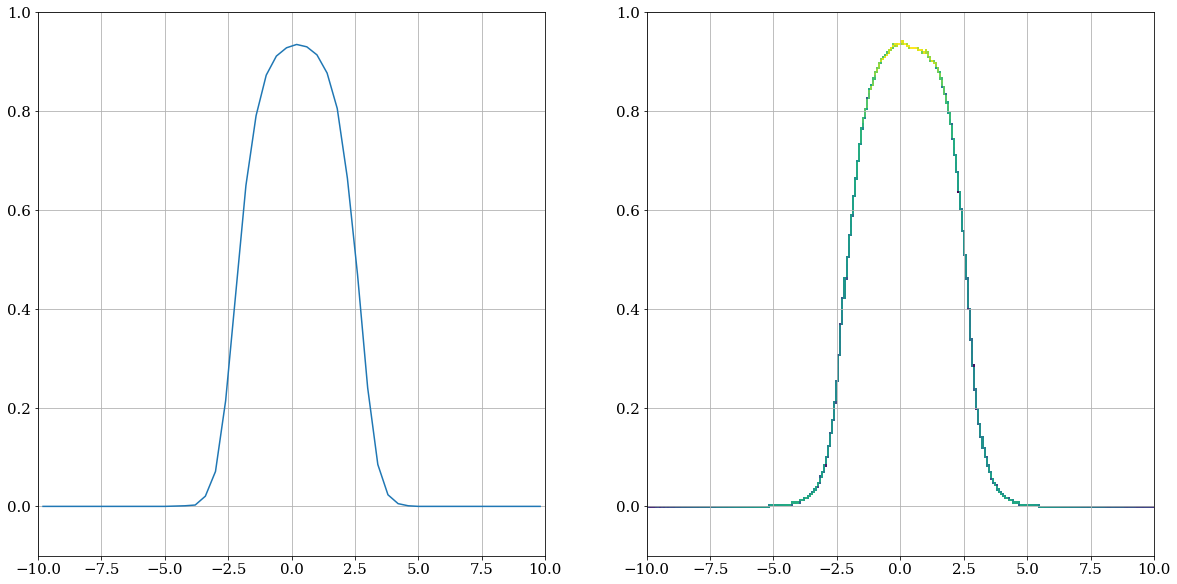

In [46]:
fig,ax = plt.subplots(1,2,figsize=(20,10))


ax[0].plot(hist_axis_centers,signal_frac)
ax[0].set_ylim(-0.1,1)
ax[0].set_xlim(-10,10)
ax[0].grid()

ax[1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data_bgsub_only,
         density=True,
         bins=250,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1].grid()

plt.show()

In [47]:
of_training_history = np.zeros(shape=(4,2,1000))
of_training_history_val = np.zeros(shape=(4,2,1000))


## OmniFold part starts here

In [48]:
# initial iterative weights are ones
weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [49]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))
yvals_1 = np.concatenate((labels0, np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))))

In [50]:
%%time



for i in range(iterations):
    print("\n\n\nITERATION: {}\n".format(i + 1))

    

    print("\n\n\n")
    print (strftime("Current time:  %Y-%m-%d %H:%M:%S", gmtime()))
    print("\n\n\n")    
    
    
    
    
    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("\n\n\n Iteration %d,  STEP 1, events that pass reco\n\n\n" % (i+1))
    

    weights_1 = np.concatenate((weights_push, w_data))
    #QUESTION: concatenation here confuses me
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1) #REMINDER: made up of synthetic+measured

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])


    stopwatch.reset()
    stopwatch.start()

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    stopwatch.stop()
    print("\n\n model.compile took this long:  %.2f" % stopwatch.elapsed )

    stopwatch.reset()
    stopwatch.start()
    
    
    
    this_hist = model.fit(X_train_1[X_train_1!=dummyval],
              Y_train_1[X_train_1!=dummyval],
              sample_weight=w_train_1[X_train_1!=dummyval],
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1[X_test_1!=dummyval], Y_test_1[X_test_1!=dummyval], w_test_1[X_test_1!=dummyval]),
              callbacks=[earlystopping],
              verbose=1)

    stopwatch.stop()
    print("\n\n model.fit took this long:  %.2f" % stopwatch.elapsed )


    
    
    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,0,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,0,ei] = this_hist.history['val_loss'][ei]
    
    
    weights_pull = weights_push * reweight(theta0_S) 
    #QUESTION: above model used in reweight function (model.predict)?
    #QUESTION: Model trains until synthetic is indistinguishable from data? How does this work? 
    #How are weights then iteratively multiplied?
 

    ##-- owen: save NN output for each iteration, step.
    nn_output[i,0,:] = np.squeeze(  model.predict(theta0_S, batch_size=10000) )



    
    
    
    print("\n\n\n")
    print (strftime("Current time:  %Y-%m-%d %H:%M:%S", gmtime()))
    print("\n\n\n")    
    

    print("\n\n\n Iteration %d,  STEP 1, events that do NOT pass reco\n\n\n" % (i+1))

    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_G[theta0_S!=dummyval],theta0_G[theta0_S!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_G[theta0_S!=dummyval])),np.zeros(len(theta0_G[theta0_S!=dummyval]))])
    weights_1b = np.concatenate([weights_pull[theta0_S!=dummyval],np.ones(len(theta0_G[theta0_S!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])



    stopwatch.reset()
    stopwatch.start()
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])

    
    
    stopwatch.stop()
    print("\n\n model.compile took this long:  %.2f" % stopwatch.elapsed )

    stopwatch.reset()
    stopwatch.start()
    
    this_hist = model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)

    stopwatch.stop()
    print("\n\n model.fit took this long:  %.2f" % stopwatch.elapsed )
        
        
        
        
        
        
        
    
    
    
    
    average_vals = reweight(theta0_G[theta0_S==dummyval])
    weights_pull[theta0_S==dummyval] = average_vals
    ###
    
    
    ##-- owen: the syntax below is a bit confusing.
    #          it is equivalent to weights[i,0,:] I think.  See Python-syntax-testing notebook.
    weights[i, :1, :] = weights_pull
    
    
    
    
    
    
    
    
    
    
    

    
    
    
    print("\n\n\n")
    print (strftime("Current time:  %Y-%m-%d %H:%M:%S", gmtime()))
    print("\n\n\n")    
    
    

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\n\n\n Iteration %d,  STEP 2, events that pass reco\n\n\n" % (i+1))

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    


    stopwatch.reset()
    stopwatch.start()
        
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    

    stopwatch.stop()
    print("\n\n model.compile took this long:  %.2f" % stopwatch.elapsed )

    stopwatch.reset()
    stopwatch.start()
    
 
    this_hist = model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    stopwatch.stop()
    print("\n\n model.fit took this long:  %.2f" % stopwatch.elapsed )
    
    
    
    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,1,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,1,ei] = this_hist.history['val_loss'][ei]        
    
    
    
    weights_push = reweight(theta0_G)    
    
    ##-- owen: save NN output for each iteration, step.
    nn_output[i,1,:] = np.squeeze(  model.predict(theta0_G, batch_size=10000) )
 





    print("\n\n\n")
    print (strftime("Current time:  %Y-%m-%d %H:%M:%S", gmtime()))
    print("\n\n\n")    
    
    
    print("\n\n\n Iteration %d,  STEP 2, events that do NOT pass reco\n\n\n" % (i+1))
    

    ###
    #Need to do something with events that don't pass truth    
    
    #One option is to take the prior:
    #weights_push[theta0_G==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_reco>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_S[theta0_G!=dummyval],theta0_S[theta0_G!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_S[theta0_G!=dummyval])),np.zeros(len(theta0_S[theta0_G!=dummyval]))])
    weights_1b = np.concatenate([weights_push[theta0_G!=dummyval],np.ones(len(theta0_S[theta0_G!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])

    stopwatch.reset()
    stopwatch.start()
        
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    

    stopwatch.stop()
    print("\n\n model.compile took this long:  %.2f" % stopwatch.elapsed )

    stopwatch.reset()
    stopwatch.start()
    
     
    
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)

    stopwatch.stop()
    print("\n\n model.fit took this long:  %.2f" % stopwatch.elapsed )
    
    average_vals = reweight(theta0_S[theta0_G==dummyval])
    weights_push[theta0_G==dummyval] = average_vals
    ###    

    
    ##-- owen: the syntax below is a bit confusing.
    #          it is equivalent to weights[i,1,:] I think.  See Python-syntax-testing notebook.
    
    weights[i, 1:2, :] = weights_push
    
    
    
    
    
    
    

print("\n\n\n")
print (strftime("Current time:  %Y-%m-%d %H:%M:%S", gmtime()))
print("\n\n\n")    
        
    
    




ITERATION: 1





Current time:  2023-01-27 02:35:24







 Iteration 1,  STEP 1, events that pass reco





 model.compile took this long:  0.00
Epoch 1/200
92/92 [==============================] - 79s 865ms/step - loss: 0.6173 - accuracy: 0.5222 - val_loss: 0.6157 - val_accuracy: 0.5309
Epoch 2/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.5307 - val_loss: 0.6155 - val_accuracy: 0.5298
Epoch 3/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.5292 - val_loss: 0.6154 - val_accuracy: 0.5293
Epoch 4/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.5290 - val_loss: 0.6154 - val_accuracy: 0.5287
Epoch 5/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.5286 - val_loss: 0.6154 - val_accuracy: 0.5283
Epoch 6/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.5285 - val_loss: 0.6154 - val_accuracy: 0.5277
E

Epoch 58/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.5287 - val_loss: 0.6153 - val_accuracy: 0.5287
Epoch 59/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.5288 - val_loss: 0.6153 - val_accuracy: 0.5291
Epoch 60/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.5289 - val_loss: 0.6153 - val_accuracy: 0.5282
Epoch 61/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.5287 - val_loss: 0.6153 - val_accuracy: 0.5286
Epoch 62/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.5287 - val_loss: 0.6153 - val_accuracy: 0.5276
Epoch 63/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.5286 - val_loss: 0.6153 - val_accuracy: 0.5285
Epoch 64/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.5286 - val_loss: 0.6153 - val_accuracy: 0.5283
Epoch 

92/92 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.5323 - val_loss: 0.6152 - val_accuracy: 0.5315
Epoch 173/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.5324 - val_loss: 0.6152 - val_accuracy: 0.5328
Epoch 174/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.5323 - val_loss: 0.6152 - val_accuracy: 0.5313
Epoch 175/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.5322 - val_loss: 0.6152 - val_accuracy: 0.5334
Epoch 176/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.5332 - val_loss: 0.6152 - val_accuracy: 0.5322
Epoch 177/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.5322 - val_loss: 0.6152 - val_accuracy: 0.5326
Epoch 178/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.5331 - val_loss: 0.6152 - val_accuracy: 0.5331
Epoch 179/200

Epoch 83: early stopping


 model.fit took this long:  299.97
11/11 [==============================] - 0s 675us/step




Current time:  2023-01-27 02:46:37







 Iteration 1,  STEP 2, events that pass reco





 model.compile took this long:  0.00
Epoch 1/200
92/92 [==============================] - 76s 829ms/step - loss: 0.6916 - accuracy: 0.4998 - val_loss: 0.6919 - val_accuracy: 0.5006
Epoch 2/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.4997 - val_loss: 0.6918 - val_accuracy: 0.5005
Epoch 3/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5000 - val_loss: 0.6918 - val_accuracy: 0.5006
Epoch 4/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.4998 - val_loss: 0.6918 - val_accuracy: 0.5005
Epoch 5/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.4998 - val_loss: 0.6919 - val_accuracy: 0.5005
Epoch 6/200
92/92 [=======================

Epoch 57/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.4997 - val_loss: 0.6918 - val_accuracy: 0.5004
Epoch 58/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.4998 - val_loss: 0.6920 - val_accuracy: 0.5006
Epoch 59/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.4999 - val_loss: 0.6919 - val_accuracy: 0.5004
Epoch 60/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5001 - val_loss: 0.6918 - val_accuracy: 0.5005
Epoch 61/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.5004
Epoch 62/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.4999 - val_loss: 0.6919 - val_accuracy: 0.5005
Epoch 62: early stopping


 model.fit took this long:  320.90
100/100 [==============================] - 0s 614us/step




Current time:  2023-01-27

Epoch 54/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.5387 - val_loss: 0.6277 - val_accuracy: 0.5386
Epoch 55/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.5385 - val_loss: 0.6277 - val_accuracy: 0.5409
Epoch 56/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.5387 - val_loss: 0.6277 - val_accuracy: 0.5408
Epoch 57/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.5390 - val_loss: 0.6277 - val_accuracy: 0.5388
Epoch 58/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.5386 - val_loss: 0.6277 - val_accuracy: 0.5406
Epoch 59/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.5387 - val_loss: 0.6277 - val_accuracy: 0.5410
Epoch 60/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.5391 - val_loss: 0.6277 - val_accuracy: 0.5359
Epoch 

92/92 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.5393 - val_loss: 0.6277 - val_accuracy: 0.5420
Epoch 168: early stopping


 model.fit took this long:  368.82
100/100 [==============================] - 0s 565us/step




Current time:  2023-01-27 03:03:06







 Iteration 2,  STEP 1, events that do NOT pass reco





 model.compile took this long:  0.00
Epoch 1/200
83/83 [==============================] - 72s 879ms/step - loss: 0.6915 - accuracy: 0.5002 - val_loss: 0.6843 - val_accuracy: 0.4997
Epoch 2/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5001 - val_loss: 0.6841 - val_accuracy: 0.4998
Epoch 3/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5002 - val_loss: 0.6840 - val_accuracy: 0.4998
Epoch 4/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5000 - val_loss: 0.6840 - val_accuracy: 0.4996
Epoch 5/200
83/83 [=========================

92/92 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.4999 - val_loss: 0.6842 - val_accuracy: 0.5002
Epoch 41/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5002 - val_loss: 0.6842 - val_accuracy: 0.5003
Epoch 42/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.4997 - val_loss: 0.6842 - val_accuracy: 0.5002
Epoch 43/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.4997 - val_loss: 0.6842 - val_accuracy: 0.5002
Epoch 43: early stopping


 model.fit took this long:  324.09
100/100 [==============================] - 0s 582us/step




Current time:  2023-01-27 03:13:38







 Iteration 2,  STEP 2, events that do NOT pass reco





 model.compile took this long:  0.00
Epoch 1/200
83/83 [==============================] - 71s 860ms/step - loss: 0.6877 - accuracy: 0.4998 - val_loss: 0.6875 - val_accuracy: 0.5002
Epoch 2/200
83/83 [=======================

Epoch 3/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.5332 - val_loss: 0.6271 - val_accuracy: 0.5346
Epoch 4/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.5350 - val_loss: 0.6271 - val_accuracy: 0.5416
Epoch 5/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.5387 - val_loss: 0.6271 - val_accuracy: 0.5382
Epoch 6/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.5376 - val_loss: 0.6271 - val_accuracy: 0.5430
Epoch 7/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.5385 - val_loss: 0.6271 - val_accuracy: 0.5420
Epoch 8/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.5393 - val_loss: 0.6271 - val_accuracy: 0.5412
Epoch 9/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.5407 - val_loss: 0.6271 - val_accuracy: 0.5312
Epoch 10/200


Epoch 61/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.5397 - val_loss: 0.6271 - val_accuracy: 0.5445
Epoch 62/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.5393 - val_loss: 0.6271 - val_accuracy: 0.5452
Epoch 62: early stopping


 model.fit took this long:  327.06
100/100 [==============================] - 0s 593us/step




Current time:  2023-01-27 03:23:59







 Iteration 3,  STEP 1, events that do NOT pass reco





 model.compile took this long:  0.00
Epoch 1/200
83/83 [==============================] - 73s 883ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6824 - val_accuracy: 0.4998
Epoch 2/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.5002 - val_loss: 0.6818 - val_accuracy: 0.4996
Epoch 3/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.5001 - val_loss: 0.6816 - val_accuracy: 0.4990
Epoch 4/200
83/83 [============

Epoch 111/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5001 - val_loss: 0.6817 - val_accuracy: 0.4990
Epoch 112/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5001 - val_loss: 0.6816 - val_accuracy: 0.4997
Epoch 113/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5002 - val_loss: 0.6816 - val_accuracy: 0.4990
Epoch 114/200
83/83 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.5003 - val_loss: 0.6816 - val_accuracy: 0.4991
Epoch 115/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5000 - val_loss: 0.6815 - val_accuracy: 0.4990
Epoch 116/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5002 - val_loss: 0.6816 - val_accuracy: 0.4997
Epoch 117/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5003 - val_loss: 0.6816 - val_accuracy: 0.4990

Epoch 32/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.4998 - val_loss: 0.6810 - val_accuracy: 0.5012
Epoch 33/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.4997 - val_loss: 0.6810 - val_accuracy: 0.5008
Epoch 34/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.4994 - val_loss: 0.6810 - val_accuracy: 0.5008
Epoch 35/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.4999 - val_loss: 0.6810 - val_accuracy: 0.5012
Epoch 36/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.4997 - val_loss: 0.6810 - val_accuracy: 0.5008
Epoch 37/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.4997 - val_loss: 0.6810 - val_accuracy: 0.5008
Epoch 38/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.4996 - val_loss: 0.6810 - val_accuracy: 0.5013
Epoch 

Epoch 39/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5333 - val_loss: 0.6274 - val_accuracy: 0.5085
Epoch 40/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5275 - val_loss: 0.6274 - val_accuracy: 0.5410
Epoch 41/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5333 - val_loss: 0.6274 - val_accuracy: 0.5022
Epoch 42/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5276 - val_loss: 0.6274 - val_accuracy: 0.5100
Epoch 43/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5268 - val_loss: 0.6274 - val_accuracy: 0.5139
Epoch 44/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5226 - val_loss: 0.6274 - val_accuracy: 0.5370
Epoch 45/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5323 - val_loss: 0.6274 - val_accuracy: 0.5362
Epoch 

Epoch 97/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5269 - val_loss: 0.6274 - val_accuracy: 0.5411
Epoch 98/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5285 - val_loss: 0.6274 - val_accuracy: 0.5394
Epoch 99/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5343 - val_loss: 0.6274 - val_accuracy: 0.5088
Epoch 100/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5291 - val_loss: 0.6274 - val_accuracy: 0.5054
Epoch 101/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5275 - val_loss: 0.6274 - val_accuracy: 0.5422
Epoch 102/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5340 - val_loss: 0.6274 - val_accuracy: 0.5451
Epoch 103/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5302 - val_loss: 0.6274 - val_accuracy: 0.5122
Ep

Epoch 102/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.4998 - val_loss: 0.6810 - val_accuracy: 0.5005
Epoch 103/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.4999 - val_loss: 0.6810 - val_accuracy: 0.5010
Epoch 104/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.4998 - val_loss: 0.6810 - val_accuracy: 0.5005
Epoch 105/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.4997 - val_loss: 0.6810 - val_accuracy: 0.5011
Epoch 106/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.4997 - val_loss: 0.6810 - val_accuracy: 0.5012
Epoch 107/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.4994 - val_loss: 0.6810 - val_accuracy: 0.5006
Epoch 108/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.4999 - val_loss: 0.6810 - val_accuracy: 0.5010

Epoch 3/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5001 - val_loss: 0.6838 - val_accuracy: 0.4995
Epoch 4/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5000 - val_loss: 0.6839 - val_accuracy: 0.4997
Epoch 5/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5000 - val_loss: 0.6838 - val_accuracy: 0.4994
Epoch 6/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5000 - val_loss: 0.6838 - val_accuracy: 0.4994
Epoch 7/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.4998 - val_loss: 0.6838 - val_accuracy: 0.4995
Epoch 8/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.4999 - val_loss: 0.6838 - val_accuracy: 0.4997
Epoch 9/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.4999 - val_loss: 0.6839 - val_accuracy: 0.4994
Epoch 10/200


Epoch 61/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5004 - val_loss: 0.6839 - val_accuracy: 0.4993
Epoch 62/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5002 - val_loss: 0.6838 - val_accuracy: 0.4996
Epoch 63/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5001 - val_loss: 0.6838 - val_accuracy: 0.4995
Epoch 64/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5001 - val_loss: 0.6838 - val_accuracy: 0.4996
Epoch 65/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5000 - val_loss: 0.6838 - val_accuracy: 0.4995
Epoch 66/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5002 - val_loss: 0.6838 - val_accuracy: 0.4993
Epoch 67/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5001 - val_loss: 0.6840 - val_accuracy: 0.4997
Epoch 

ITERATION 1:
ITERATION 2:
ITERATION 3:
ITERATION 4:


<Figure size 864x360 with 0 Axes>

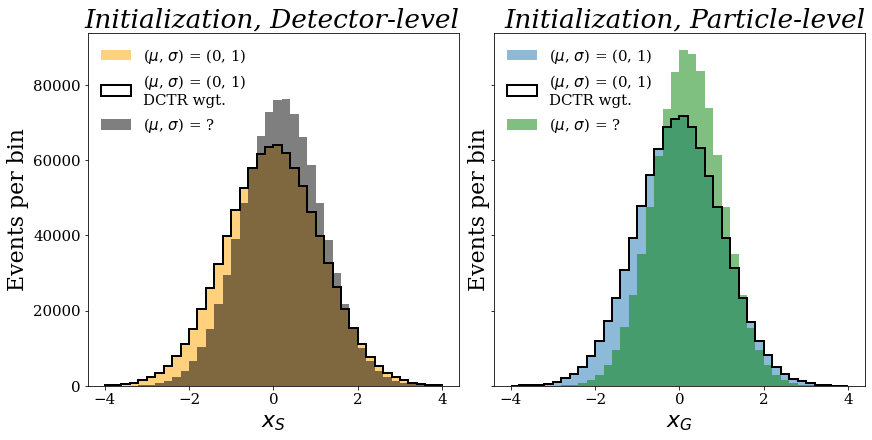

<Figure size 864x360 with 0 Axes>

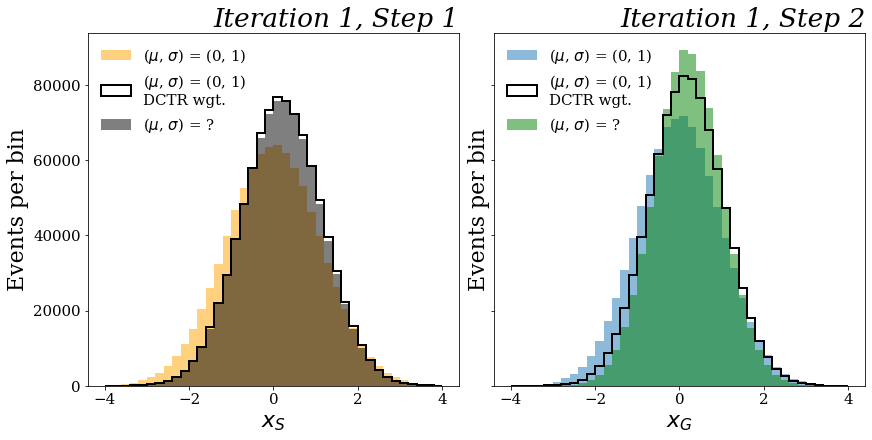

<Figure size 864x360 with 0 Axes>

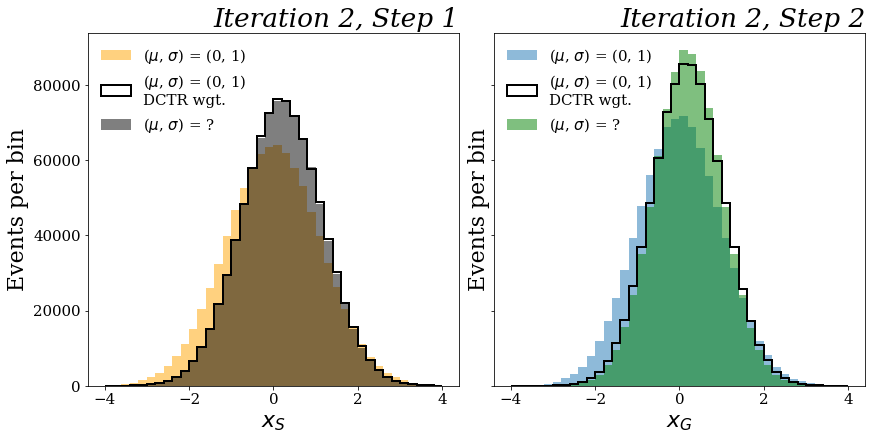

<Figure size 864x360 with 0 Axes>

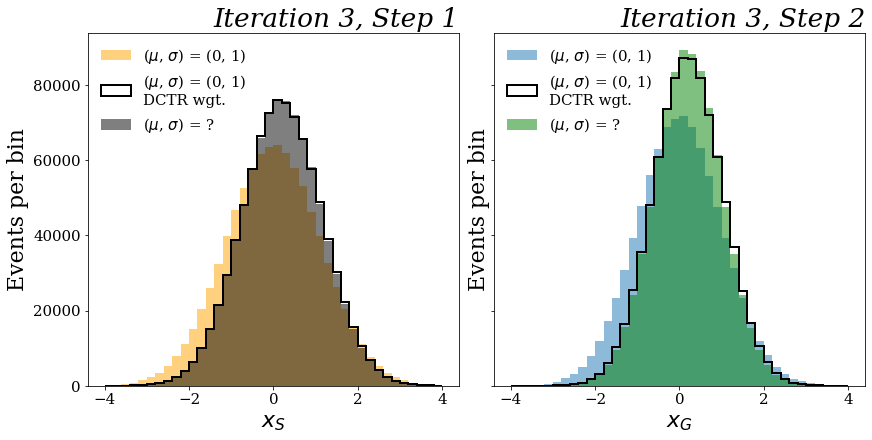

<Figure size 864x360 with 0 Axes>

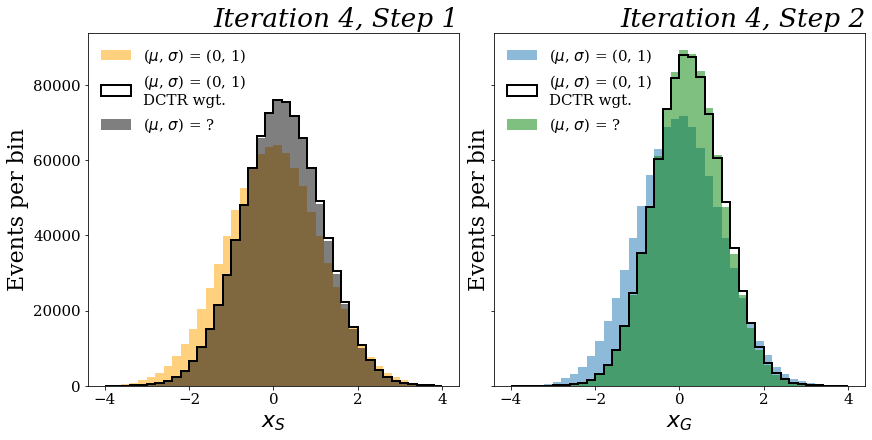

In [51]:
bins = np.linspace(-4, 4, 41)

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

#Detector-level
ax[0].set_title("Initialization, Detector-level",style='italic',loc='right')
hist0 = ax[0].hist(theta0_S[theta0_S!=dummyval],
                 bins=bins,
                 color="orange",
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[0].hist(
    theta0_S[theta0_S!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 weights=weights[i, 0, :][theta_unknown_S!=dummyval],
                 **plot_style_2,
                color="black")
ax[0].legend(frameon=False)
ax[0].set_xlabel(r"$x_S$")
ax[0].set_ylabel("Events per bin")

#Particle-level
ax[1].set_title("Initialization, Particle-level",style='italic',loc='right')
_,_,_=ax[1].hist(theta0_G[theta0_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[1].hist(
    theta0_G[theta0_G!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 **plot_style_2,
                color="green")
ax[1].legend(frameon=False)
ax[1].set_xlabel(r"$x_G$")
ax[1].set_ylabel("Events per bin")

plt.savefig("plot_0.pdf")

#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 5))
    
    fig, ax = plt.subplots(1,2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
    
    #Detector-level
    ax[0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
    _,_,_ = ax[0].hist(theta0_S[theta0_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     color="orange",
                     **plot_style_2)

    _,_,_ = ax[0].hist(
        theta0_S[theta0_S!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 0, :][theta0_S!=dummyval],
        **plot_style_1)
    _,_,_ = ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="black")
    ax[0].legend(frameon=False)
    ax[0].set_xlabel(r"$x_S$")
    ax[0].set_ylabel("Events per bin")
    
    #Particle-level
    ax[1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
    _,_,_ = ax[1].hist(theta0_G[theta0_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    _,_,_ = ax[1].hist(
        theta0_G[theta0_G!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :][theta0_G!=dummyval],
        **plot_style_1)
    _,_,_ = ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="green")
    ax[1].legend(frameon=False)
    ax[1].set_xlabel(r"$x_G$")
    ax[1].set_ylabel("Events per bin")
    
    plt.savefig("plot_"+str(i+1)+".pdf")

## Owen: inspecting a few things after running everything

In [52]:
weights

array([[[1.17708898, 1.12501872, 0.55612272, ..., 1.20813274,
         0.63053328, 1.23142135],
        [1.19691443, 1.05497217, 0.68662095, ..., 1.12792039,
         0.75342542, 1.21530592]],

       [[1.27388263, 1.1025213 , 0.55050188, ..., 1.15389681,
         0.6350382 , 1.25925004],
        [1.25497794, 1.0775038 , 0.59550792, ..., 1.12047005,
         0.68288475, 1.27170932]],

       [[1.29917979, 1.10924935, 0.54500943, ..., 1.12486351,
         0.64111847, 1.28202367],
        [1.27959943, 1.08756018, 0.56593031, ..., 1.1095947 ,
         0.65094364, 1.29053903]],

       [[1.30948007, 1.10863411, 0.54493988, ..., 1.11576223,
         0.63084477, 1.30039489],
        [1.28558314, 1.0894084 , 0.55305797, ..., 1.10376811,
         0.62875628, 1.29698443]]])

In [53]:
weights.shape

(4, 2, 1000000)

In [54]:
Input

<function keras.engine.input_layer.Input(shape=None, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None, type_spec=None, **kwargs)>

In [55]:
Model

keras.engine.training.Model

In [56]:
x_data_and_MCback

array([ 0.73995492, -1.4739263 ,  3.48357655, ..., -3.15575986,
       -0.61128483, -1.25976135])

In [57]:
x_data_and_MCback.shape

(2398668,)

In [58]:
y_data_and_MCback

array([1., 1., 1., ..., 0., 0., 0.])

In [59]:
y_data_and_MCback.shape

(2398668,)

In [60]:
W_data_and_MCback

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [61]:
W_data_and_MCback.shape

(2398668,)

In [62]:
w_data

array([0.8269643 , 0.9282346 , 0.928714  , ..., 0.05410969, 0.9099828 ,
       0.82919246], dtype=float32)

In [63]:
w_data.shape

(1099334,)

In [64]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]

array([ 1.78930588,  0.57857032, -0.32669861, ..., -3.15575986,
       -0.61128483, -1.25976135])

In [65]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval].shape

(1099334,)

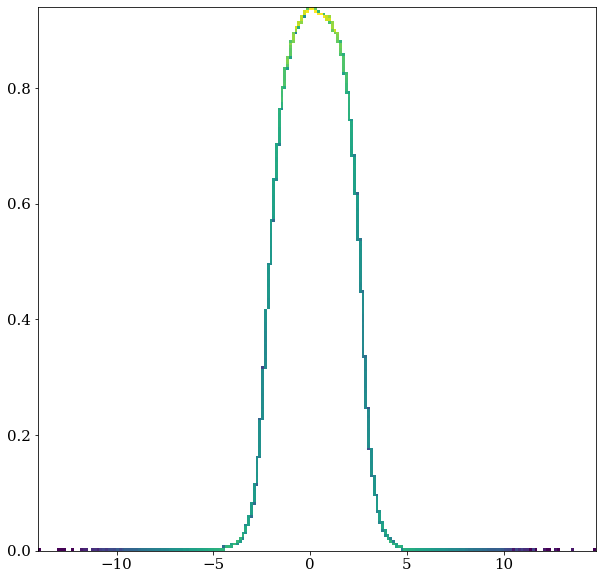

In [66]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         norm=mpl.colors.LogNorm())

plt.show()

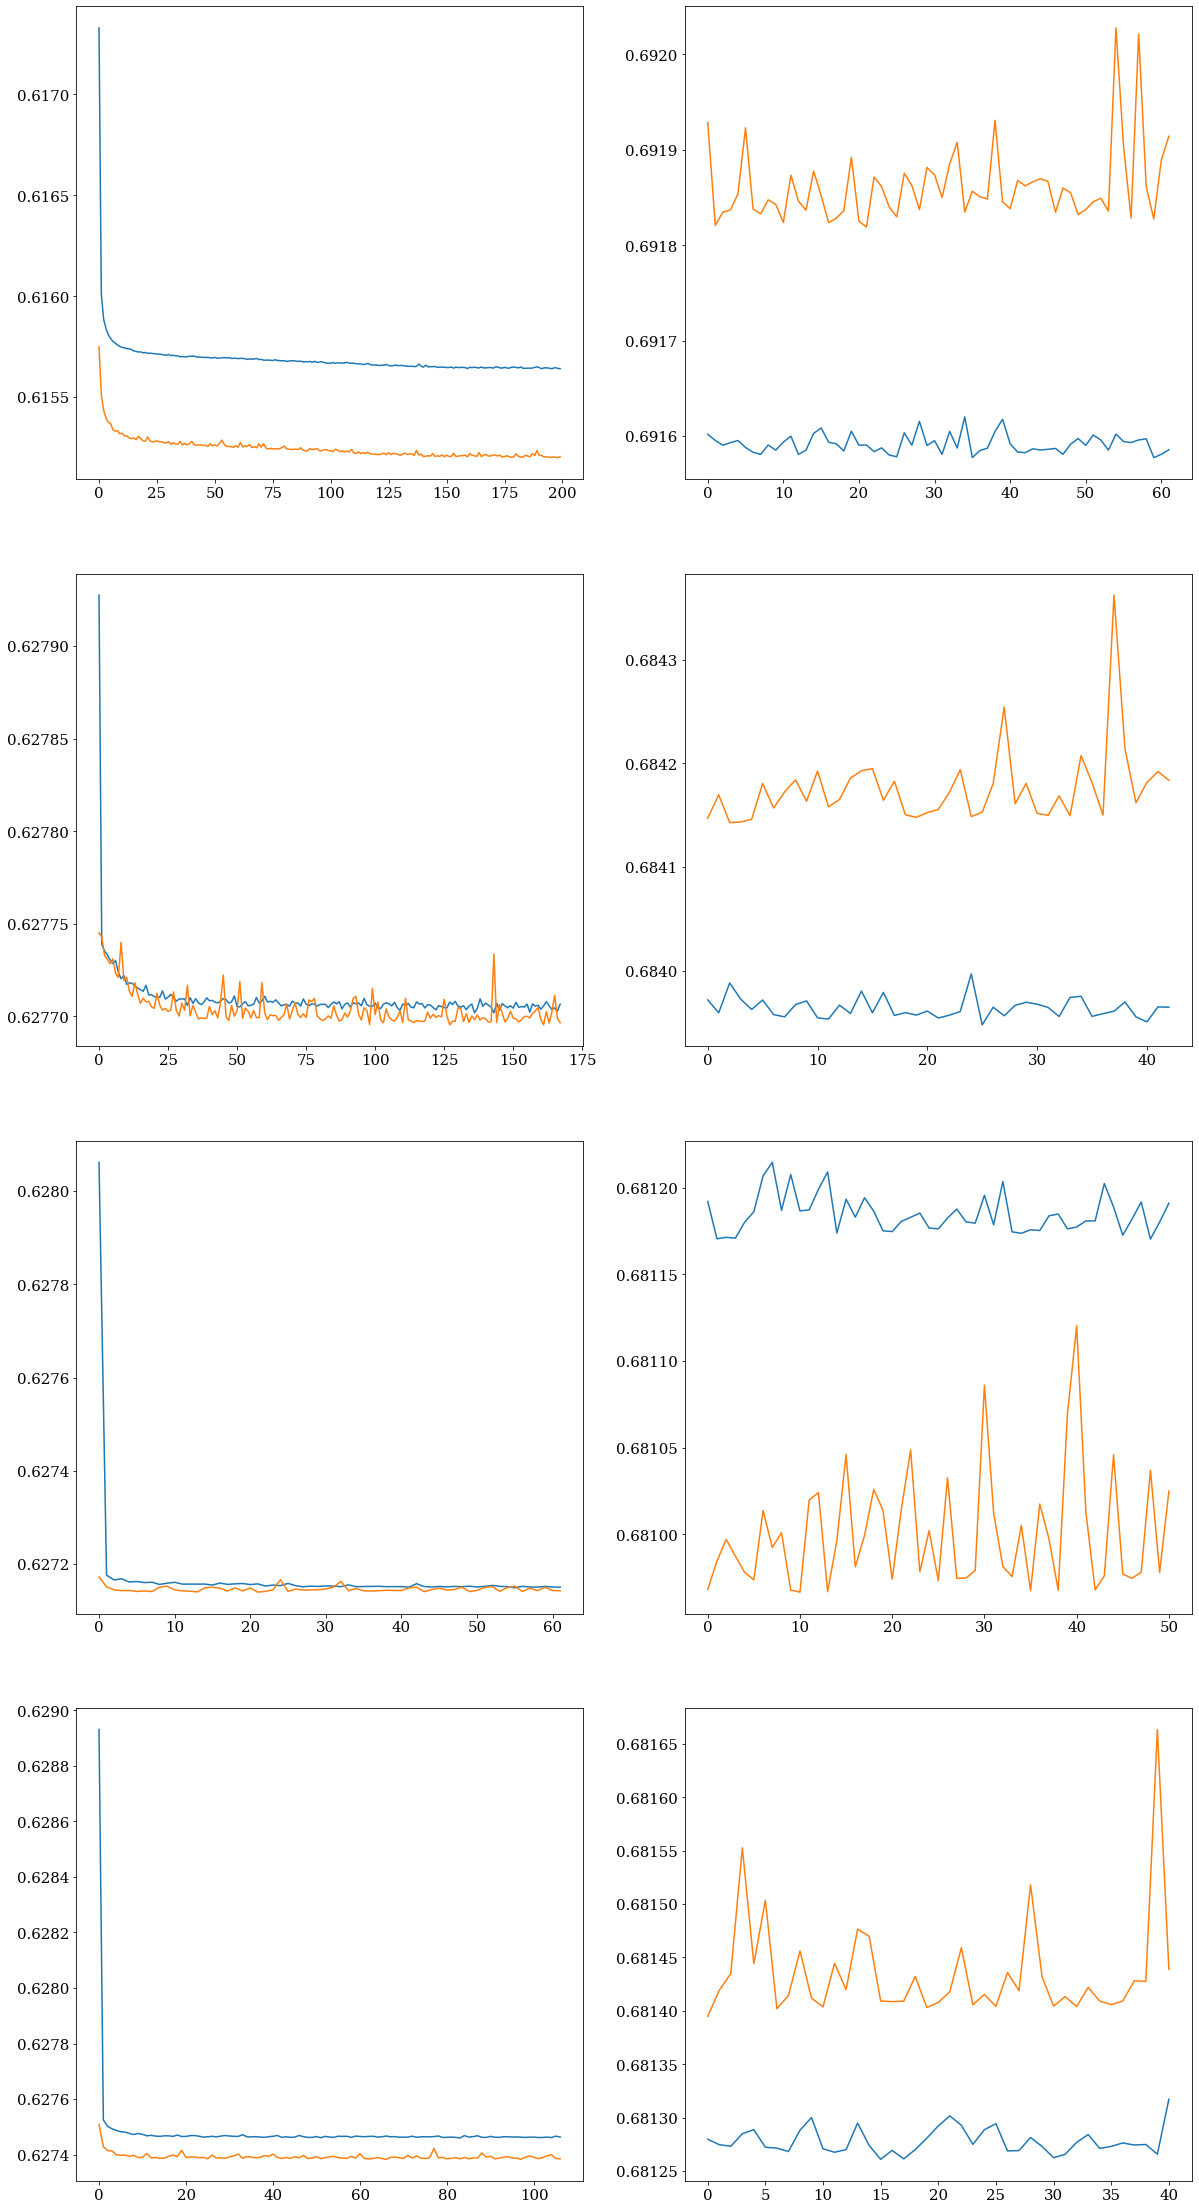

In [67]:
fig,ax = plt.subplots(4,2,figsize=(20,40))

for i in range(0,4):
    
    ax[i][0].plot( of_training_history[i][0][of_training_history[i][0]>0] )
    ax[i][0].plot( of_training_history_val[i][0][of_training_history[i][0]>0] )
    
    ax[i][1].plot( of_training_history[i][1][of_training_history[i][1]>0] )
    ax[i][1].plot( of_training_history_val[i][1][of_training_history[i][1]>0] )    
    
plt.show()

## distributions of weights

### Weights on full simulation to match data (step1)

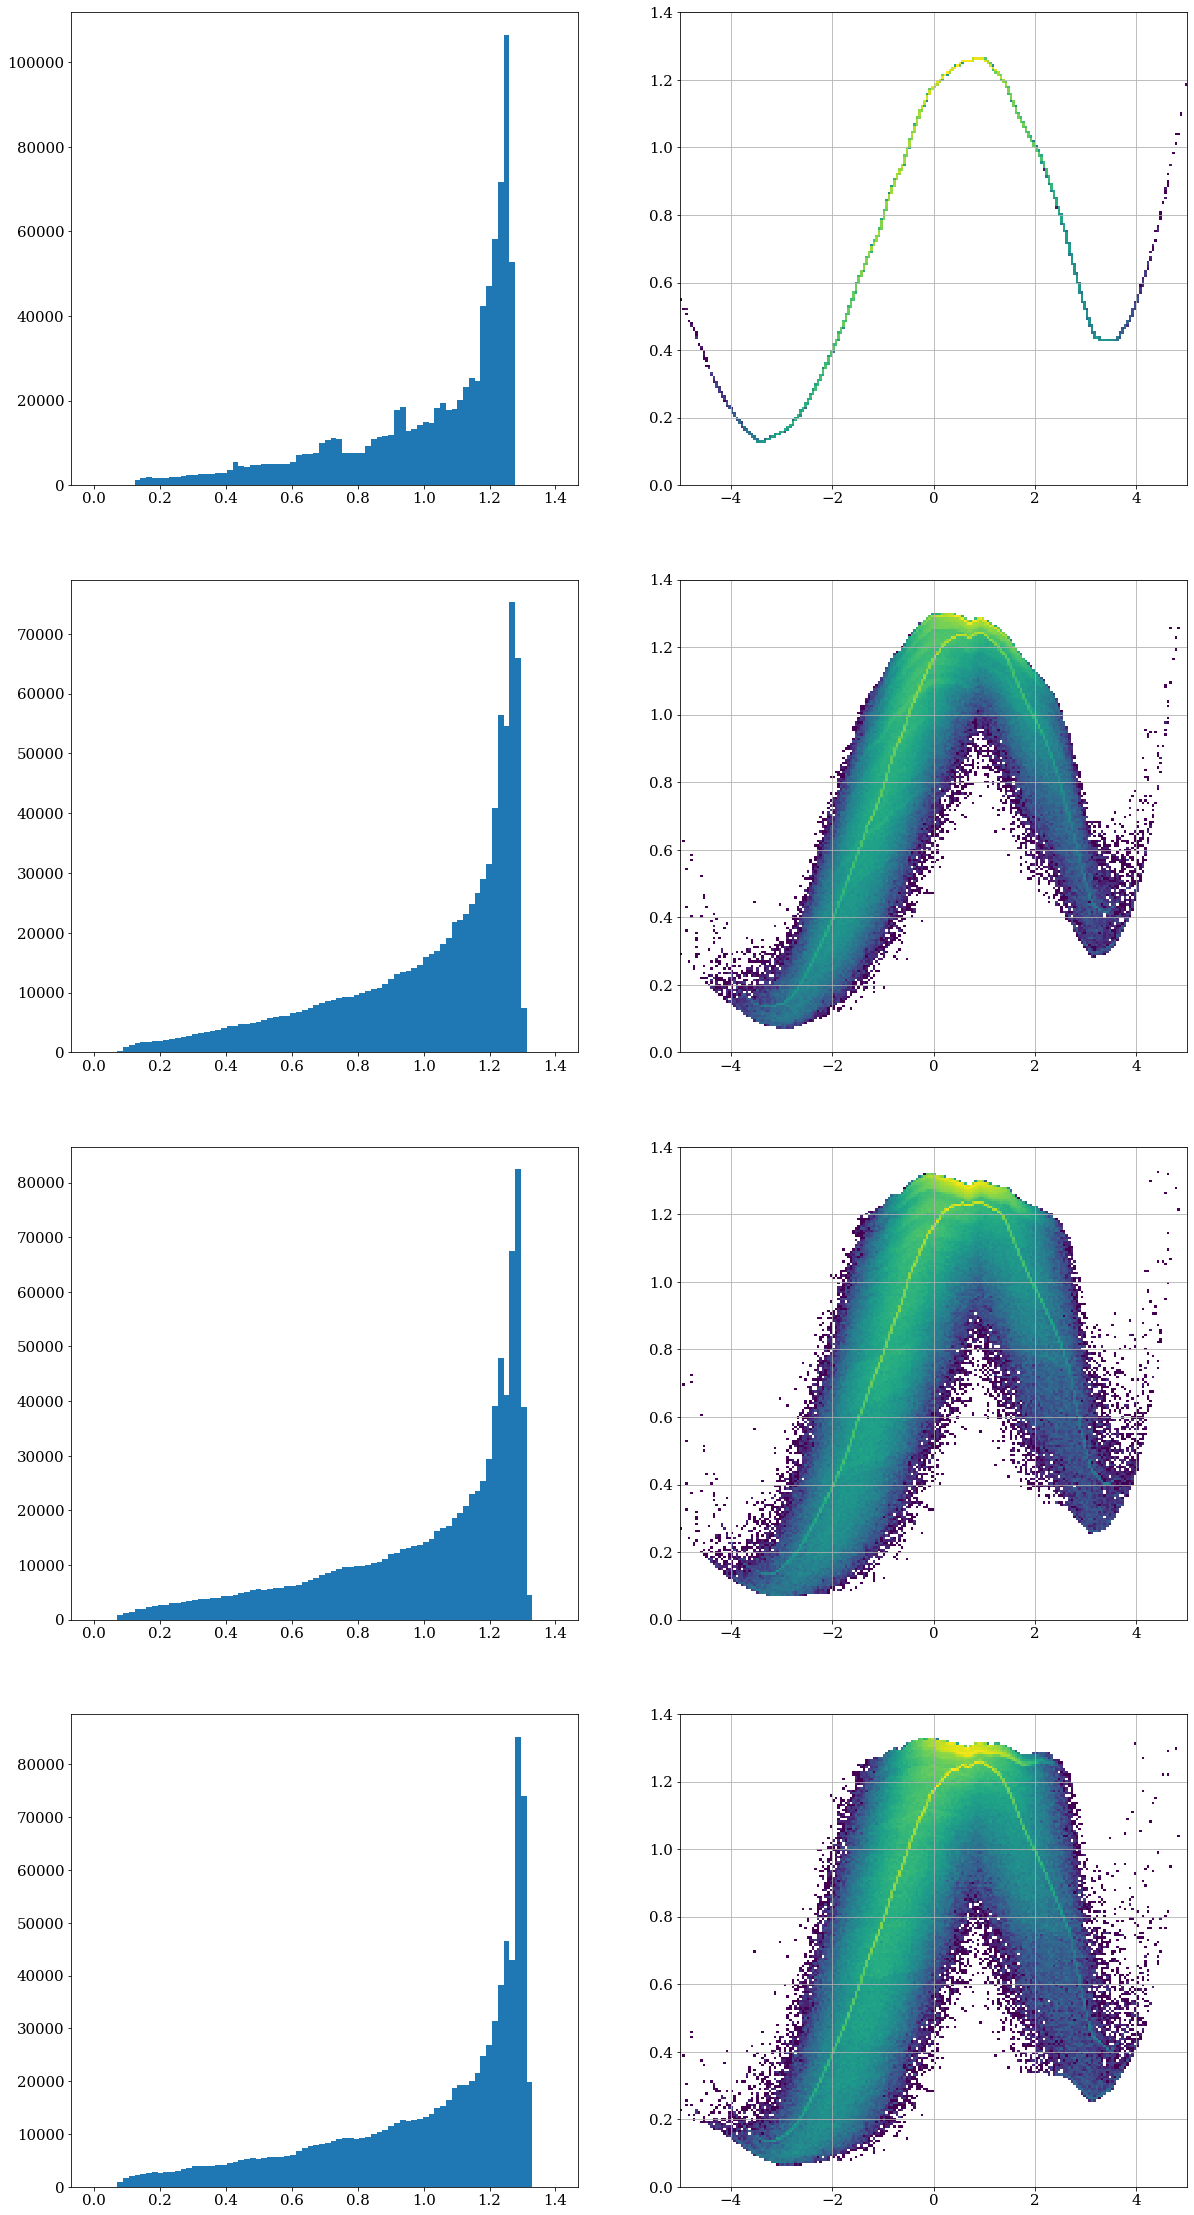

In [68]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,0,theta0_S!=dummyval], bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], weights[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

### Weights on gen (step2)

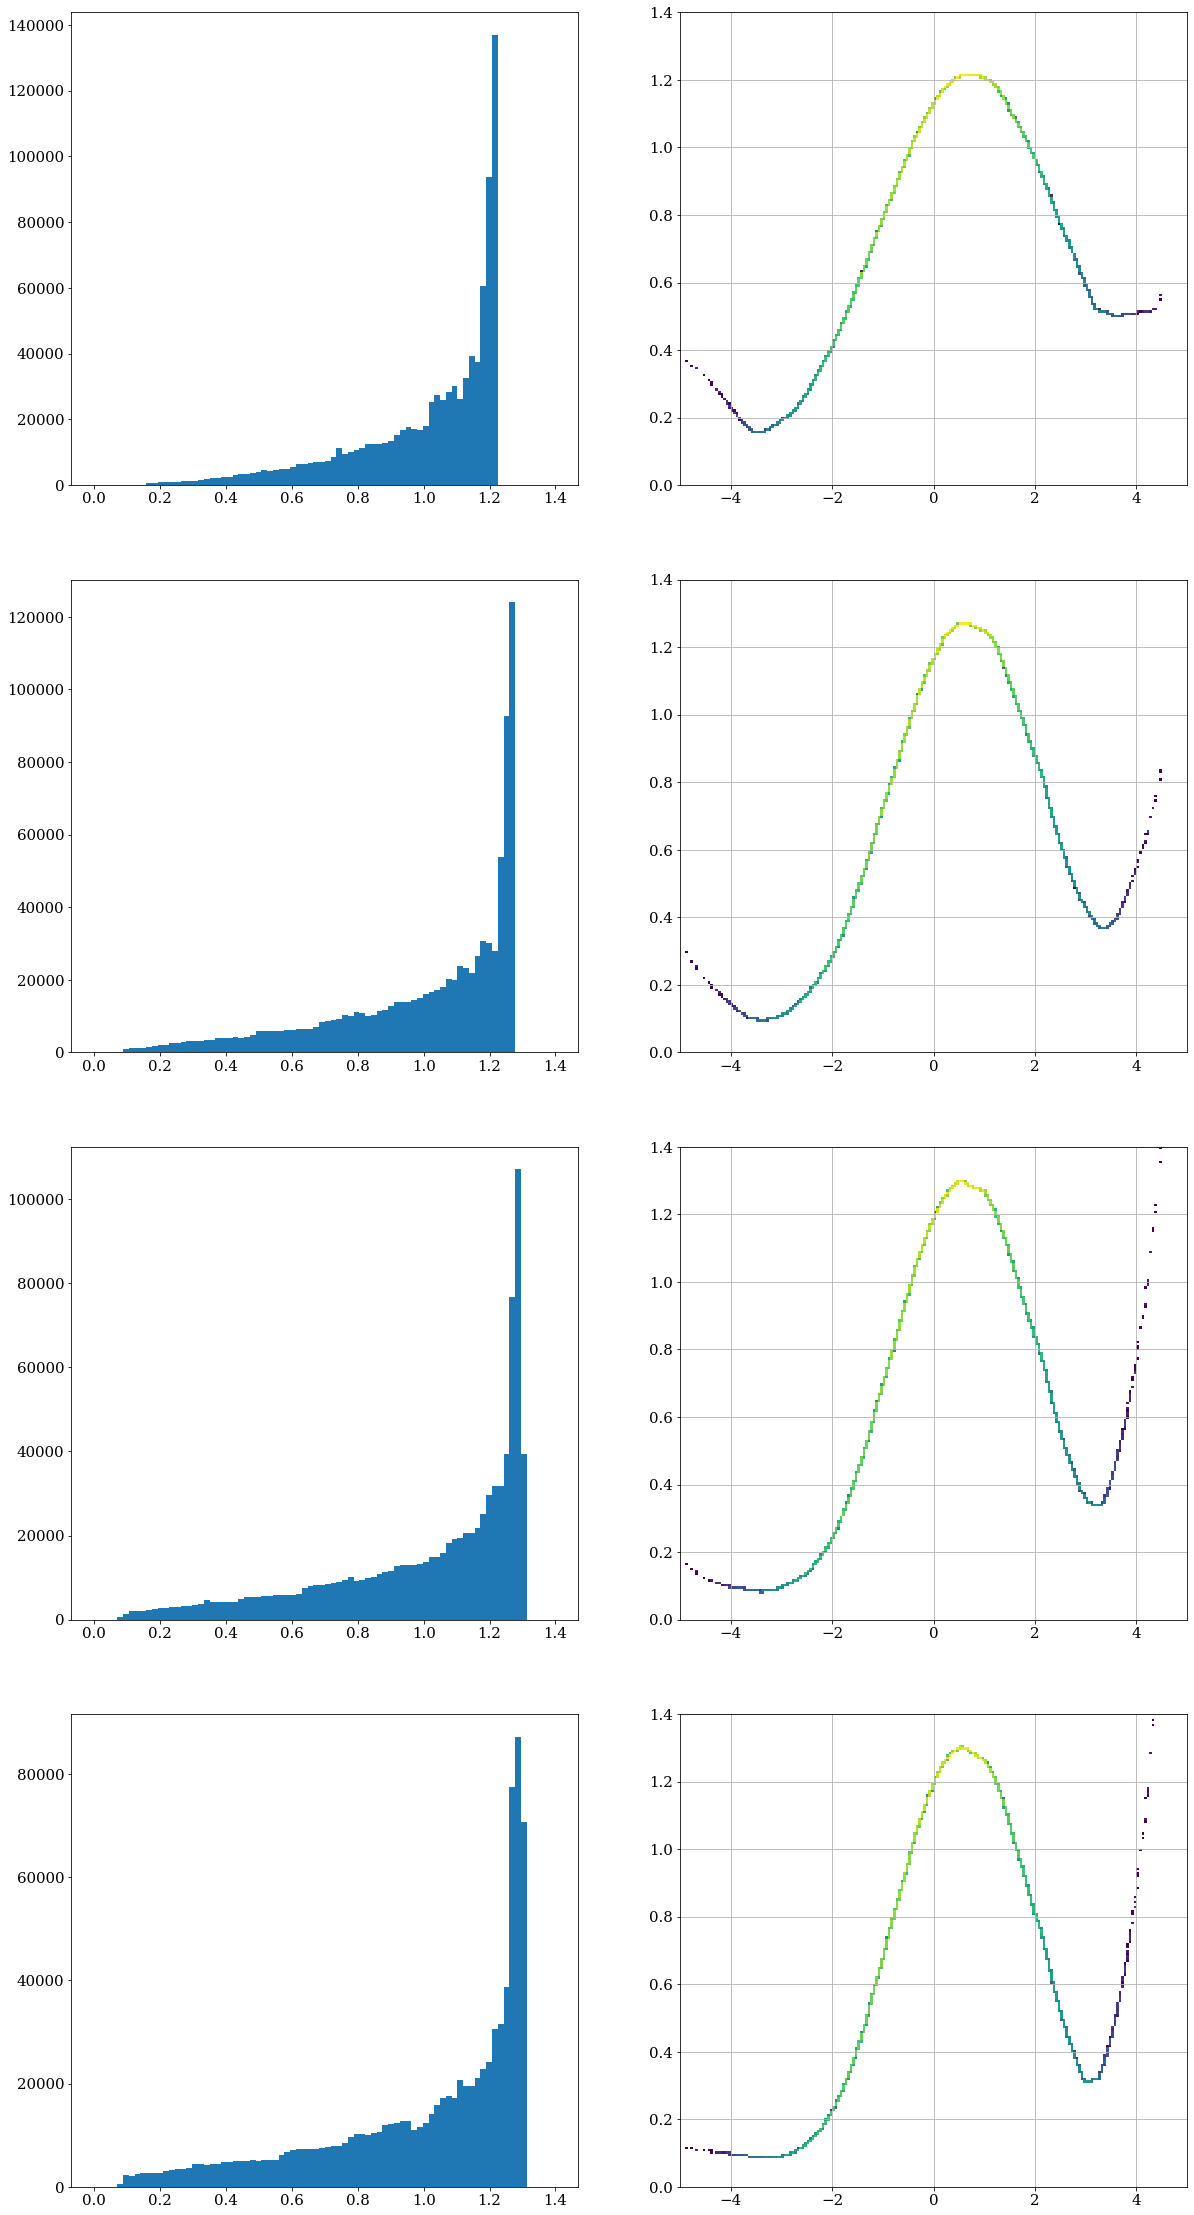

In [69]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,1,theta0_G!=dummyval], bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], weights[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

## Change in weights on fullsim (step1) between consecutive iterations

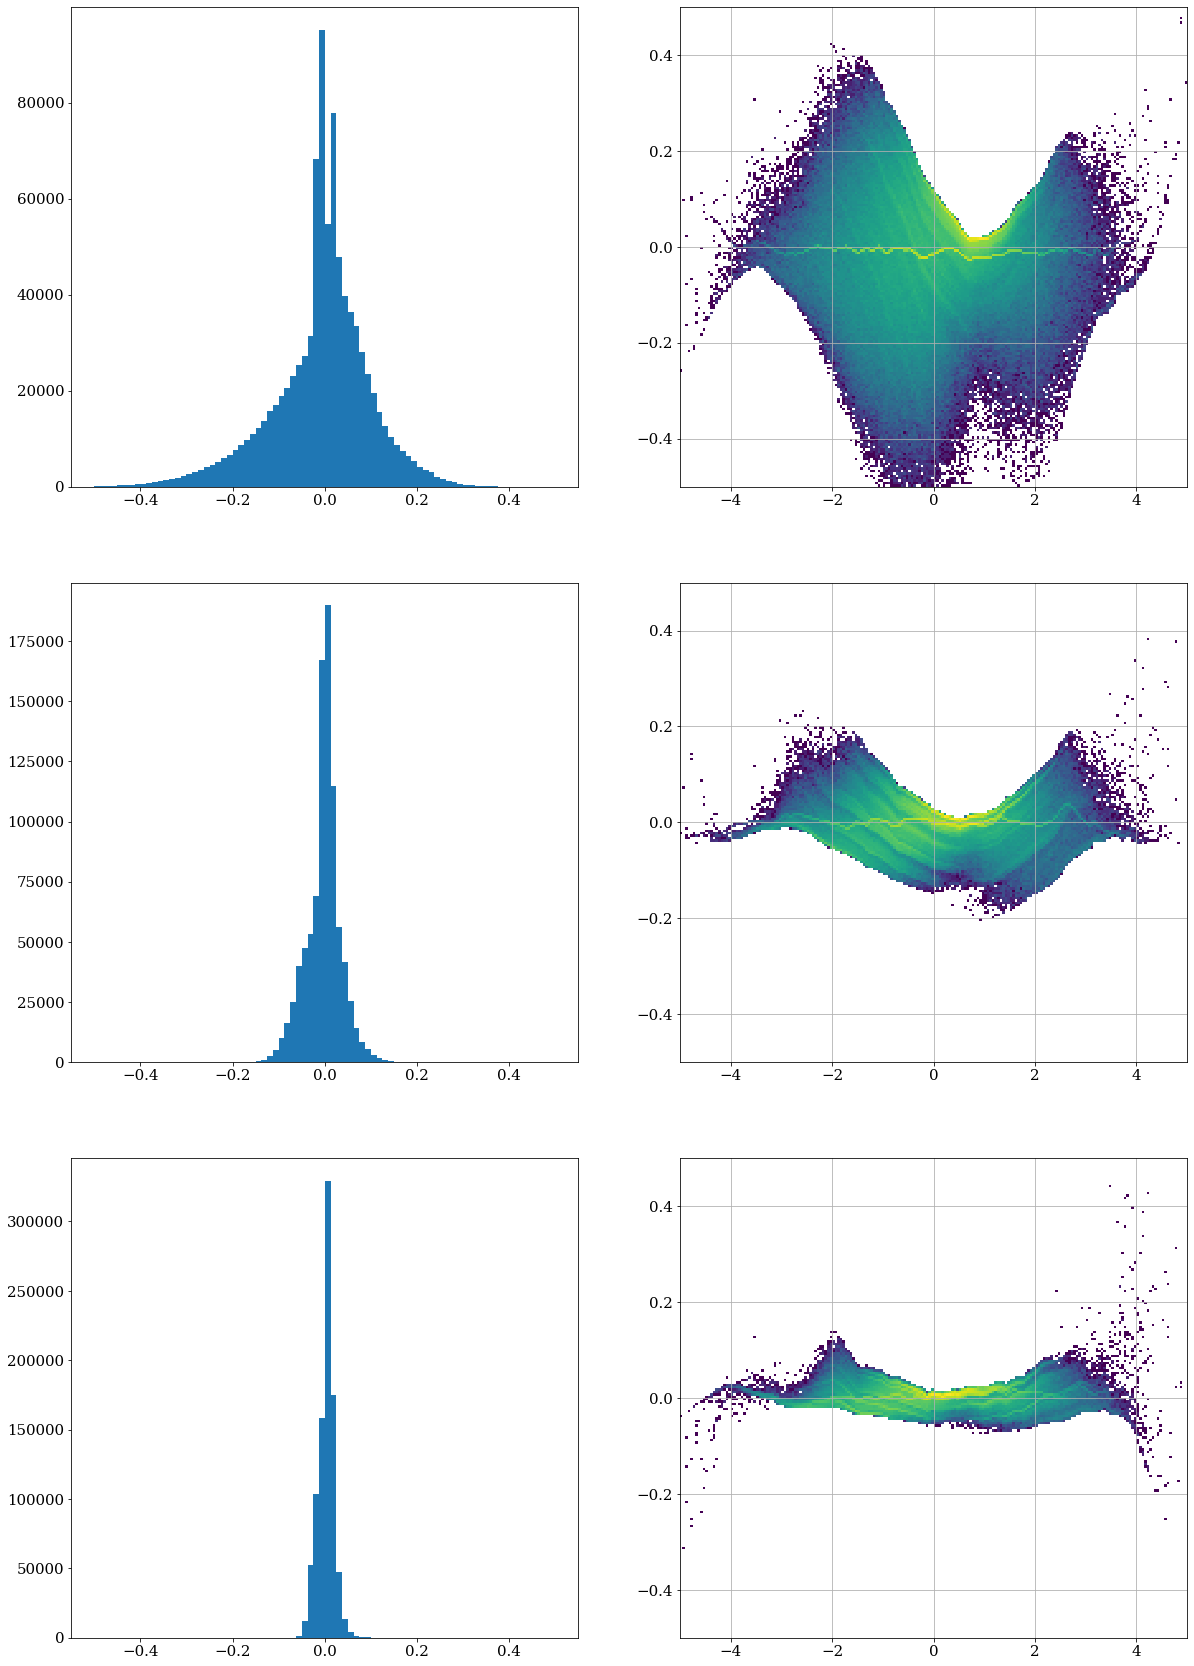

In [70]:
fig,ax = plt.subplots(iterations-1,2,figsize=(20,30))

for i in range(0,iterations-1):
    
    ax[i][0].hist( weights[i+1,0,theta0_S!=dummyval]-weights[i,0,theta0_S!=dummyval], bins=80,
                 range=[-0.5,0.5])
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], weights[i+1,0,theta0_S!=dummyval]-weights[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[-0.5,0.5]))
    ax[i][1].grid()
    
plt.show()

## Change in weights on gen (step2) between consecutive iterations

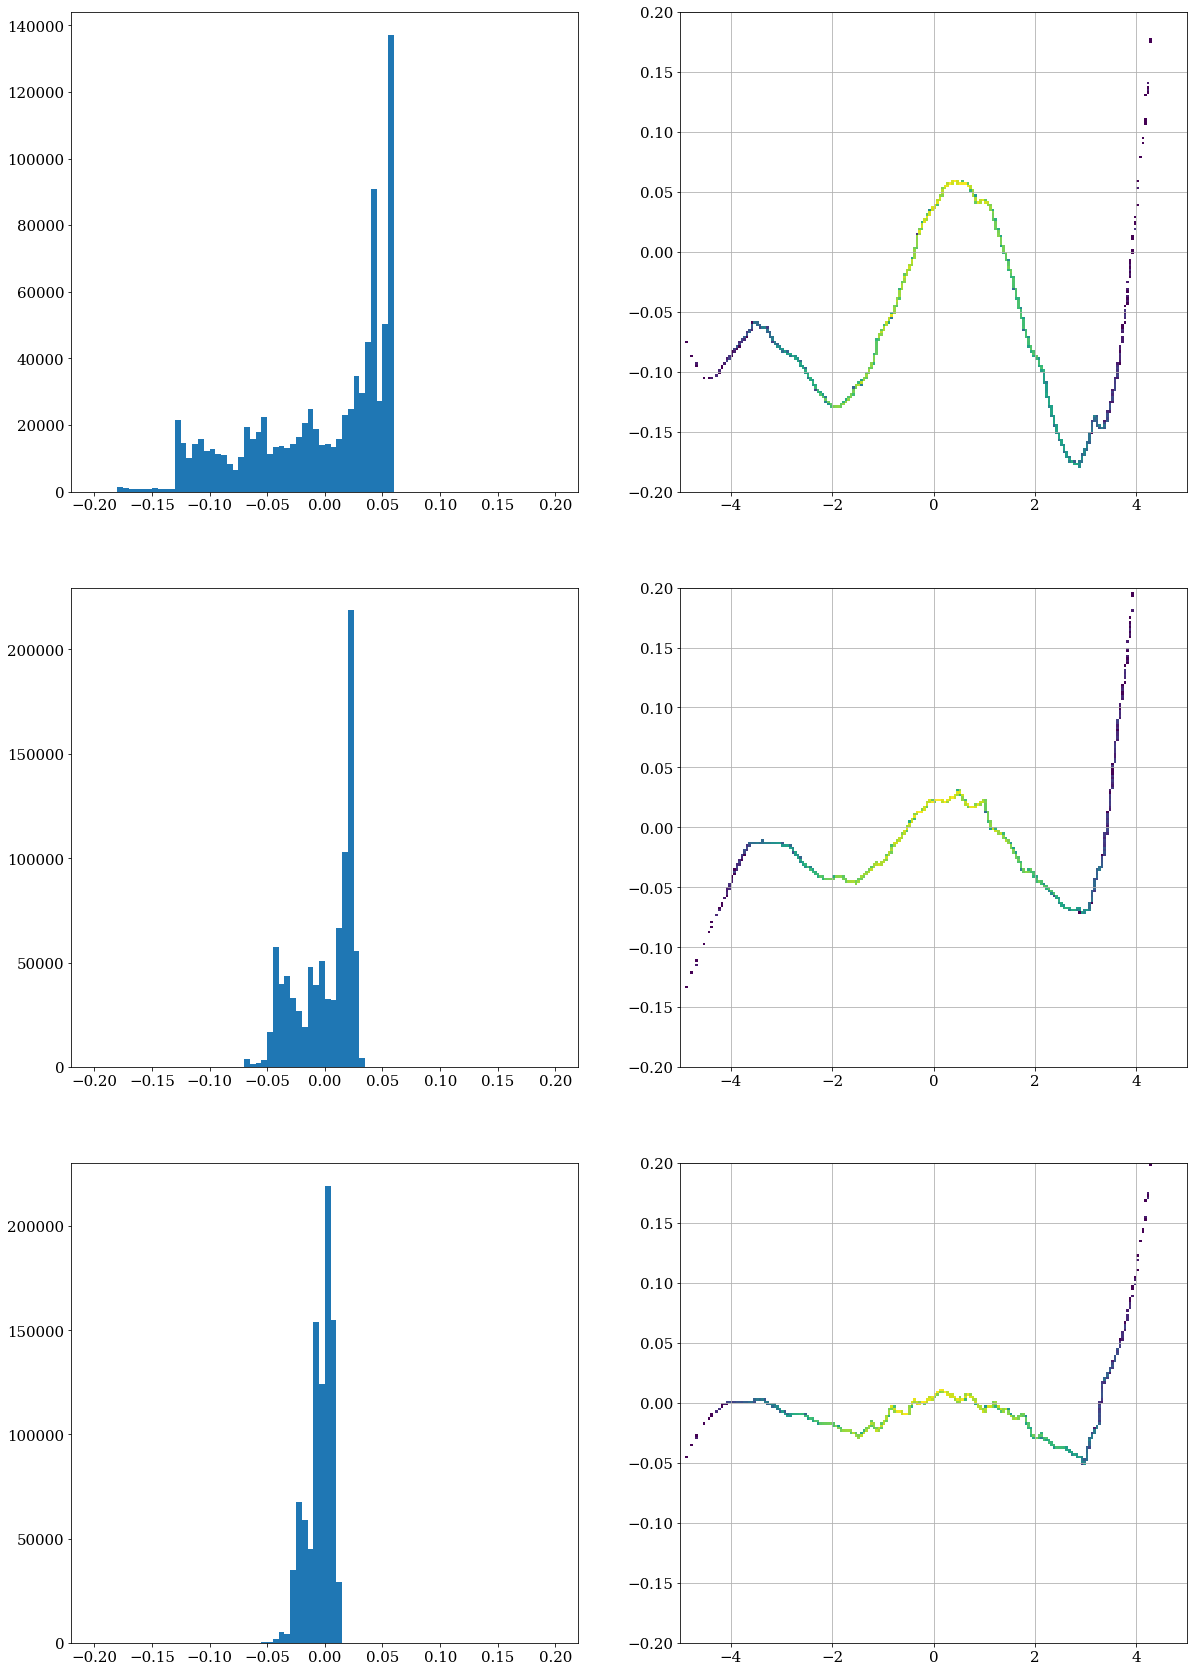

In [71]:
fig,ax = plt.subplots(iterations-1,2,figsize=(20,30))

for i in range(0,iterations-1):
    
    ax[i][0].hist( weights[i+1,1,theta0_G!=dummyval]-weights[i,1,theta0_G!=dummyval], bins=80,
                 range=[-0.2,0.2])
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], weights[i+1,1,theta0_G!=dummyval]-weights[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[-0.2,0.2]))
    ax[i][1].grid()
    
plt.show()

In [72]:
nn_output

array([[[0.54067105, 0.52941591, 0.35737714, ..., 0.54712868,
         0.3867037 , 0.55185515],
        [0.54481614, 0.50568455, 0.50568455, ..., 0.53005761,
         0.42968774, 0.54859507]],

       [[0.51557559, 0.51101953, 0.44498566, ..., 0.50569206,
         0.45736757, 0.50887918],
        [0.55653667, 0.50045514, 0.50045514, ..., 0.52840644,
         0.40578225, 0.55980283]],

       [[0.50865293, 0.50725859, 0.47786158, ..., 0.50097835,
         0.48422727, 0.50201946],
        [0.56132644, 0.50005621, 0.50005621, ..., 0.52597529,
         0.3942858 , 0.56342155]],

       [[0.5057705 , 0.50479782, 0.49055225, ..., 0.50138575,
         0.49215981, 0.50190198],
        [0.56247491, 0.5060128 , 0.5060128 , ..., 0.52466244,
         0.38603461, 0.5646466 ]]])

## Output of NN for step1: distinguish data from fullsim

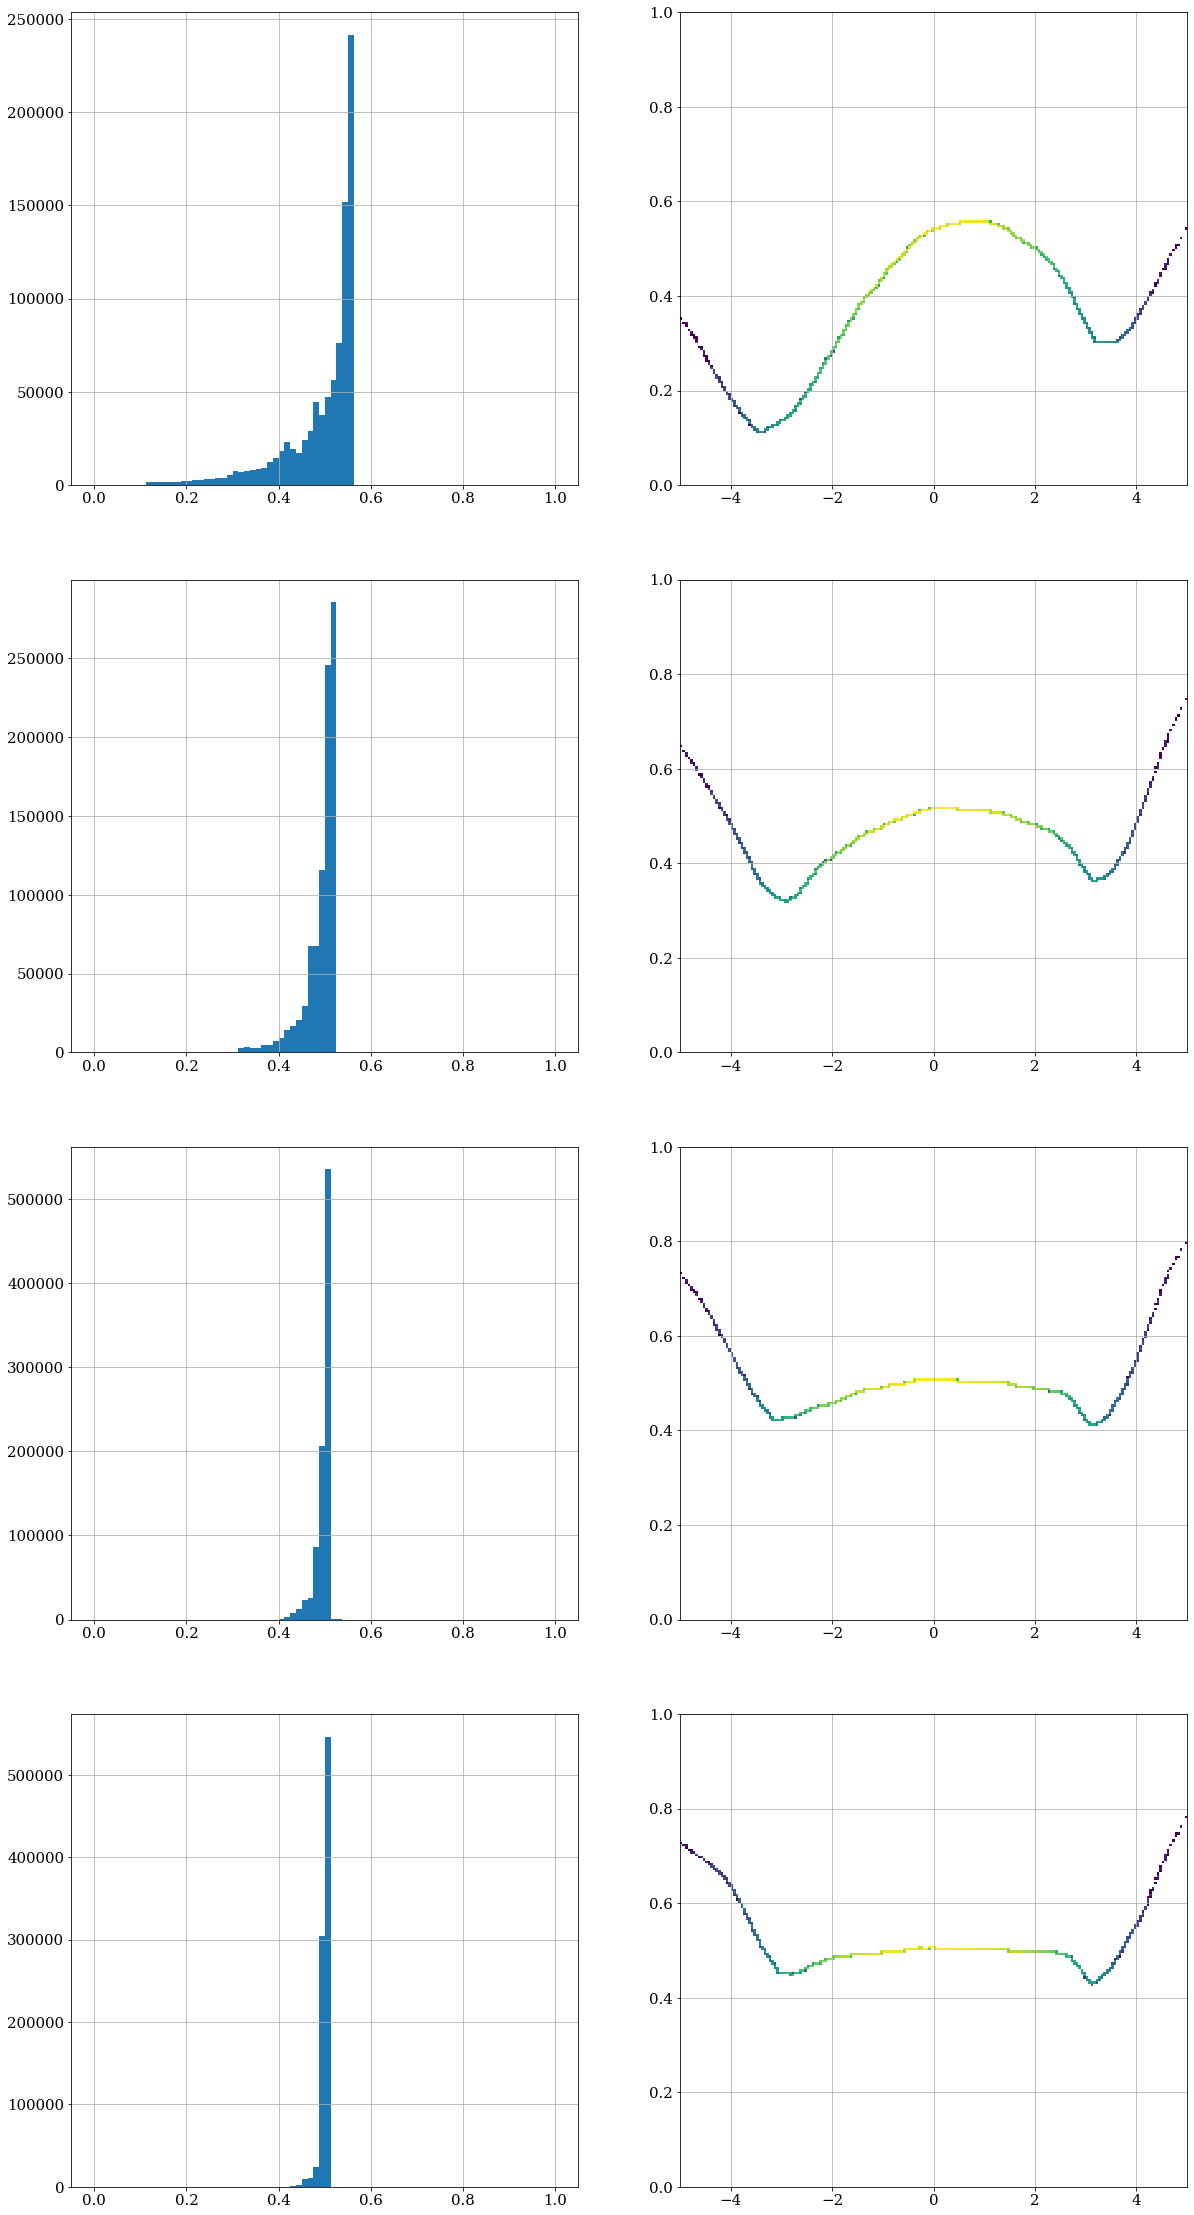

In [73]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( nn_output[i,0,theta0_S!=dummyval], bins=80, range=[0,1] )
    ax[i][0].grid()
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], nn_output[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1]))
    ax[i][1].grid()
    
plt.show()

## NN output of step2 : distinguish gen

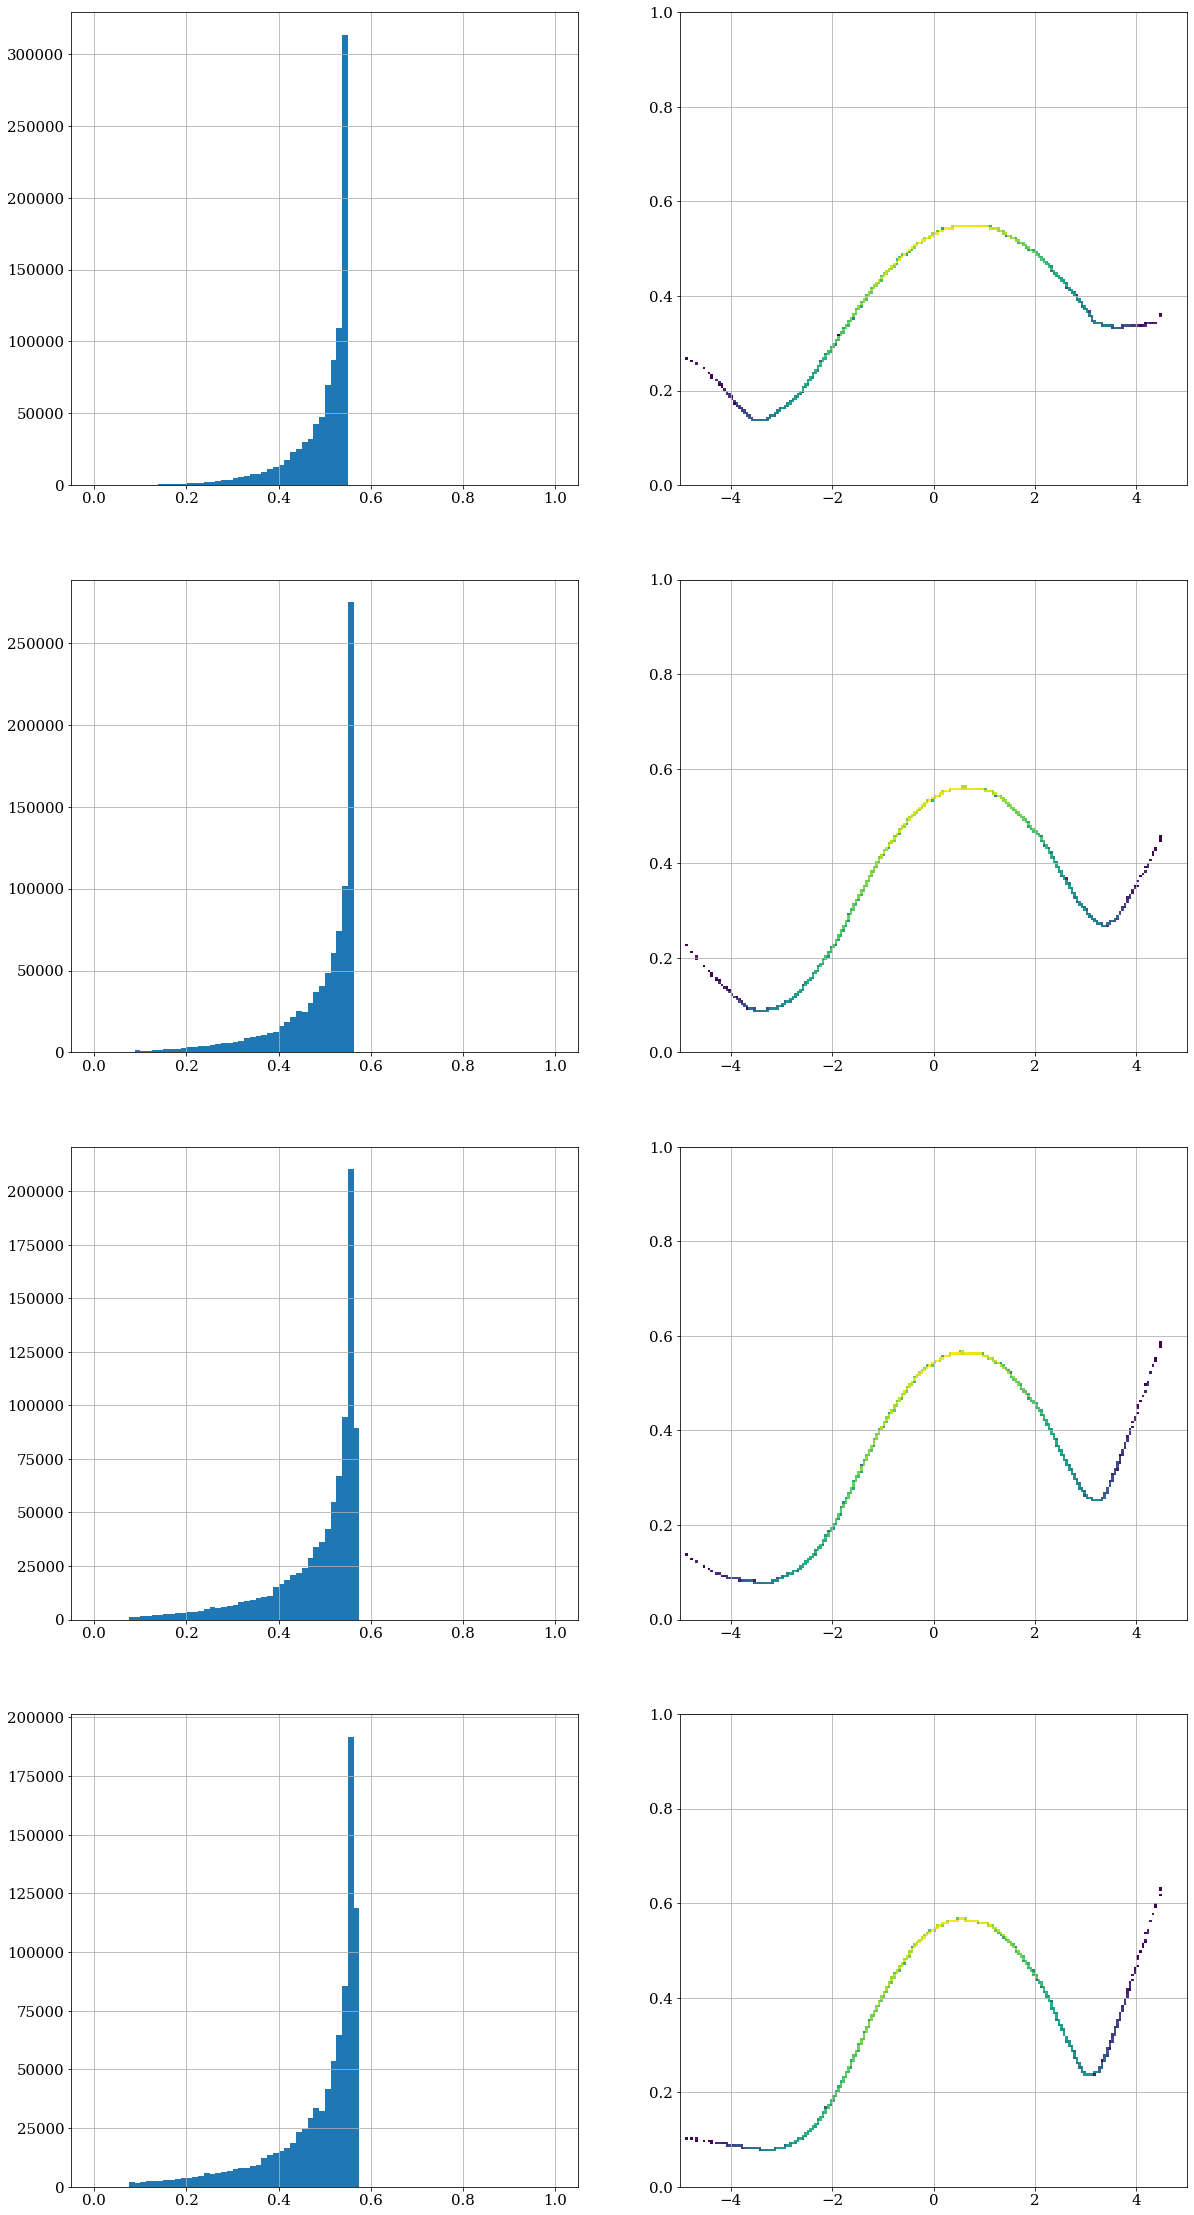

In [74]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( nn_output[i,1,theta0_G!=dummyval], bins=80, range=[0,1] )
    ax[i][0].grid()
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], nn_output[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1]))
    ax[i][1].grid()
    
plt.show()